<a href="https://colab.research.google.com/github/andreaafs/MVP-Machine-Learning-Analytics/blob/main/MVP_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: Previsão de Risco de Doenças Cardíacas

## 1. Escopo, Objetivo e Definição do Problema
- Objetivo: prever risco de doenças cardíacas (classificação binária: sim/não)
- Hipóteses iniciais: idade, pressão, colesterol e histórico familiar influenciam mais.
- Restrições: dataset público, sem dados clínicos sensíveis.

O conjunto de dados foi obtido por amostragem e adaptação do conjunto de dados original do Kaggle. Cada linha no conjunto de dados corresponde a um indivíduo diferente. Algumas colunas são as respostas a perguntas feitas aos entrevistados sobre seu estado de saúde, como:

"Você tem sérias dificuldades para andar ou subir escadas?" ou "Você fumou pelo menos 100 cigarros em toda a sua vida? O alvo é a variável Doença Cardíaca, que indica se os entrevistados que já relataram ter doença coronariana (DAC) ou infarto do miocárdio.


***OBS:*** Foram excluídas muitas linhas, pois não consegui carregar o dataset completo para o guithub


## 2. Reprodutibilidade e Ambiente

In [66]:
!pip install dython

In [67]:
# Importação de pacotes
import pandas as pd  # Series and DataFrames
import numpy as np  # linear algebra
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import math
import random
import torch

# nltk
import nltk
import ast
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from matplotlib import cm
from plotly.subplots import make_subplots
from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

# visualization
from wordcloud import WordCloud
colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']
from plotly.offline import init_notebook_mode, iplot

from dython.nominal import associations

pd.set_option('display.max_columns', None)
# from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.2f}'.format


## 3. Dados: Carga, Entendimento e Qualidade

In [68]:
def read_dataset():
    try:
        # Carregar dataset direto do GitHub
        url = "https://raw.githubusercontent.com/andreaafs/MVP-Machine-Learning-Analytics/refs/heads/main/heart_disease_data2.csv"
        df = pd.read_csv(url)

        print('"heart_disease_data.csv" imported successfully!')
        # Exibir as primeiras linhas do dataframe

        return df

    except FileNotFoundError as e:
        print(f"Erro: Arquivo não encontrado: {e}")
    except Exception as e:
        print(f"Erro ao ler o arquivo CSV: {e}")

In [69]:
df =read_dataset()

"heart_disease_data.csv" imported successfully!


Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'HeartDisease_FamilyHistory',
       'State'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303944 entries, 0 to 303943
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   target                      303943 non-null  object 
 1   BMI                         303943 non-null  float64
 2   Smoking                     303944 non-null  object 
 3   AlcoholDrinking             202440 non-null  object 
 4   Stroke                      302875 non-null  object 
 5   PhysicalHealth              303943 non-null  float64
 6   MentalHealth                303943 non-null  float64
 7   DiffWalking             

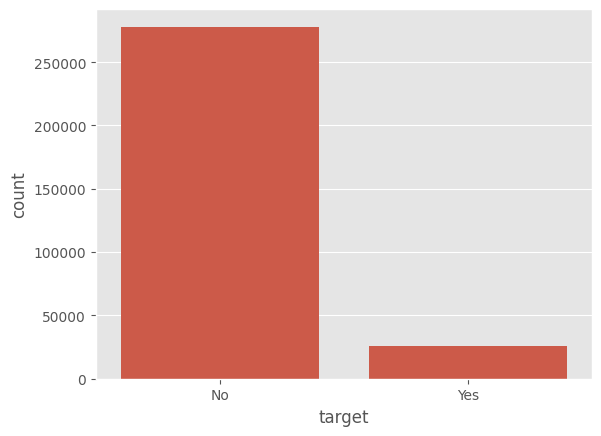

In [70]:
# Conferir colunas e renomear target caso necessário
print(df.columns)

# Definir a primeira coluna 'HeartDisease' como target
target_col = df.columns[0]
df.rename(columns={target_col: 'target'}, inplace=True)

print(df.info())
print(df.describe())
print(df.isnull().sum())
sns.countplot(x='target', data=df)
plt.show()

In [71]:
df.head(5).T

,0,1,2,3,4
target,No,Yes,No,No,No
BMI,57.02,26.43,27.63,22.81,24.33
Smoking,No,Yes,No,No,No
AlcoholDrinking,No,No,No,NaN,NaN
Stroke,No,No,No,No,No
PhysicalHealth,30.00,30.00,0.00,0.00,0.00
MentalHealth,30.00,15.00,0.00,0.00,0.00
DiffWalking,Yes,Yes,No,No,No
Sex,Female,Female,Female,Female,Male
AgeCategory,35-39,70-74,80 or older,35-39,18-24


In [72]:
df.tail(5).T

,303939,303940,303941,303942,303943
target,No,Yes,No,No,No
BMI,33.66,30.65,30.13,25.79,36.58
Smoking,No,Yes,No,No,No
AlcoholDrinking,NaN,NaN,NaN,Yes,No
Stroke,No,No,No,No,No
PhysicalHealth,0.00,2.00,0.00,0.00,30.00
MentalHealth,0.00,0.00,0.00,0.00,15.00
DiffWalking,No,No,No,No,Yes
Sex,Female,Female,Male,Male,Female
AgeCategory,30-34,65-69,25-29,80 or older,60-64


In [73]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,"303,943.00",28.32,6.37,12.02,24.03,27.32,31.38,119.00
PhysicalHealth,"303,943.00",3.36,7.94,0.00,0.00,0.00,2.00,30.00
MentalHealth,"303,943.00",3.90,7.96,0.00,0.00,0.00,3.00,30.00
SleepTime,"303,943.00",7.10,1.43,1.00,6.00,7.00,8.00,24.00


**ANALISANDO OS DADOS**

In [74]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303944 entries, 0 to 303943
Columns: 20 entries, target to State
dtypes: float64(4), object(16)
memory usage: 46.4+ MB


In [75]:
df.columns

Index(['target', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'HeartDisease_FamilyHistory',
       'State'],
      dtype='object')

**Descrição da tabela:**

Explicação Variável



*   HeartDisease (Target): Entrevistados que já relataram ter tido doença cardíaca coronária (DCC) ou infarto do miocárdio (IM)
*   BMI: Índice de Massa Corporal (IMC)
*   Smoking: Você já fumou pelo menos 100 cigarros em toda a sua vida? [Nota: 5 maços = 100 cigarros]
*   AlcoholDrinking:Bebedores pesados ​​(homens adultos que consomem mais de 14 doses por semana e mulheres adultas que consomem mais de 7 doses por semana)
*  Stroke: (Já lhe disseram) que teve um AVC?
*  PhysicalHealth:Agora pensando na sua saúde física
*  MentalHealth: Pensando na sua saúde mental
Dificuldade para Caminhar: Você tem muita dificuldade para caminhar ou subir escadas?
*  Sex: Você é homem ou mulher?
*  AgeCategory:Categoria etária de quatorze níveis
*  Race:Valor de raça/etnia imputado
*  Diabetic: (Já lhe disseram) que teve diabetes?
*  PhysicalActivity: Adultos que relataram ter praticado atividade física ou exercício nos últimos 30 dias, além do seu trabalho regular
*  GenHealth: Você diria que, em geral, sua saúde é Boa/Muito Boa/…
*  SleepTime: Em média
*  Asthma:(Já lhe disseram) que teve asma?
*  KidneyDisease: Não Incluindo cálculos renais
*  SkinCancer: (Já lhe disseram que você tinha) câncer de pele?
*  HeartDisease_FamilyHistory: Você tem histórico familiar de doença cardíaca?
*  State: US sate \EUA (residência)


In [76]:
df.head(4)

,target,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State
0,No,57.02,No,No,No,30.00,30.00,Yes,Female,35-39,White,No,No,Poor,9.00,No,No,No,NaN,TX
1,Yes,26.43,Yes,No,No,30.00,15.00,Yes,Female,70-74,White,Yes,No,Poor,6.00,No,Yes,No,NaN,AK
2,No,27.63,No,No,No,0.00,0.00,No,Female,80 or older,White,No,No,Excellent,9.00,No,No,No,NaN,SC
3,No,22.81,No,NaN,No,0.00,0.00,No,Female,35-39,White,No,Yes,Good,6.00,No,Yes,No,NaN,AZ


In [77]:
print("Total de linhas do dataframe : ",df.shape[0])

Total de linhas do dataframe :  303944



**Relatório rápido sobre dados**

In [78]:
print(df.describe(include=['object']).T)

                             count unique        top    freq
target                      303943      2         No  277994
Smoking                     303944      3         No  178669
AlcoholDrinking             202440      2         No  181686
Stroke                      302875      2         No  291496
DiffWalking                 303943      2         No  261966
Sex                         303943      2     Female  159041
AgeCategory                 303943     14      65-69   32330
Race                        303943      6      White  234439
Diabetic                    303943      4         No  256534
PhysicalActivity            303943      2        Yes  235894
GenHealth                   303943      5  Very good  108423
Asthma                      303943      2         No  263160
KidneyDisease               303943      2         No  292800
SkinCancer                  303614      2         No  275447
HeartDisease_FamilyHistory   33524      2         No   30445
State                   

#### Podemos obsersevar nos dados apresentados acima que  temos:
  * Mais mulheres;
  * Menos fumantes;
  * Faixa etária entre 65-69;
  * Raça Branca;
  * Estado predominante OH;
  * Condições de Saúde é muito boa
    
    OBS: As respostas obtidas não represemtam uma amostragem com uma variação de casos, onde podemos ter uma analise não representariva. Com a sequencias dos anos, esperamos que as respostas sejam mais representativas.

In [79]:
print(df.isnull().sum())

target                             1
BMI                                1
Smoking                            0
AlcoholDrinking               101504
Stroke                          1069
PhysicalHealth                     1
MentalHealth                       1
DiffWalking                        1
Sex                                1
AgeCategory                        1
Race                               1
Diabetic                           1
PhysicalActivity                   1
GenHealth                          1
SleepTime                          1
Asthma                             1
KidneyDisease                      1
SkinCancer                       330
HeartDisease_FamilyHistory    270420
State                              1
dtype: int64


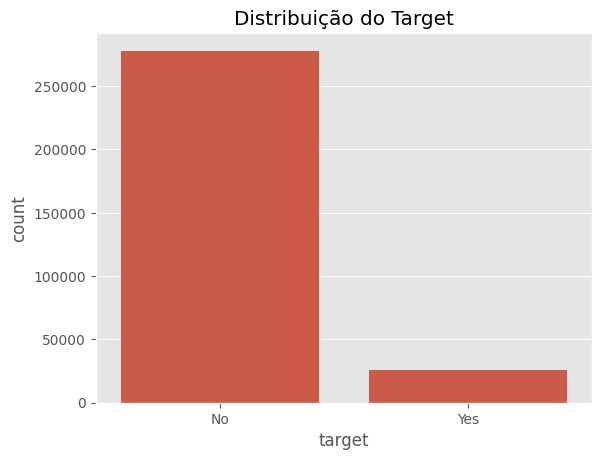

In [80]:
# ---- Distribuição do target ----
sns.countplot(x='target', data=df)
plt.title("Distribuição do Target")
plt.show()

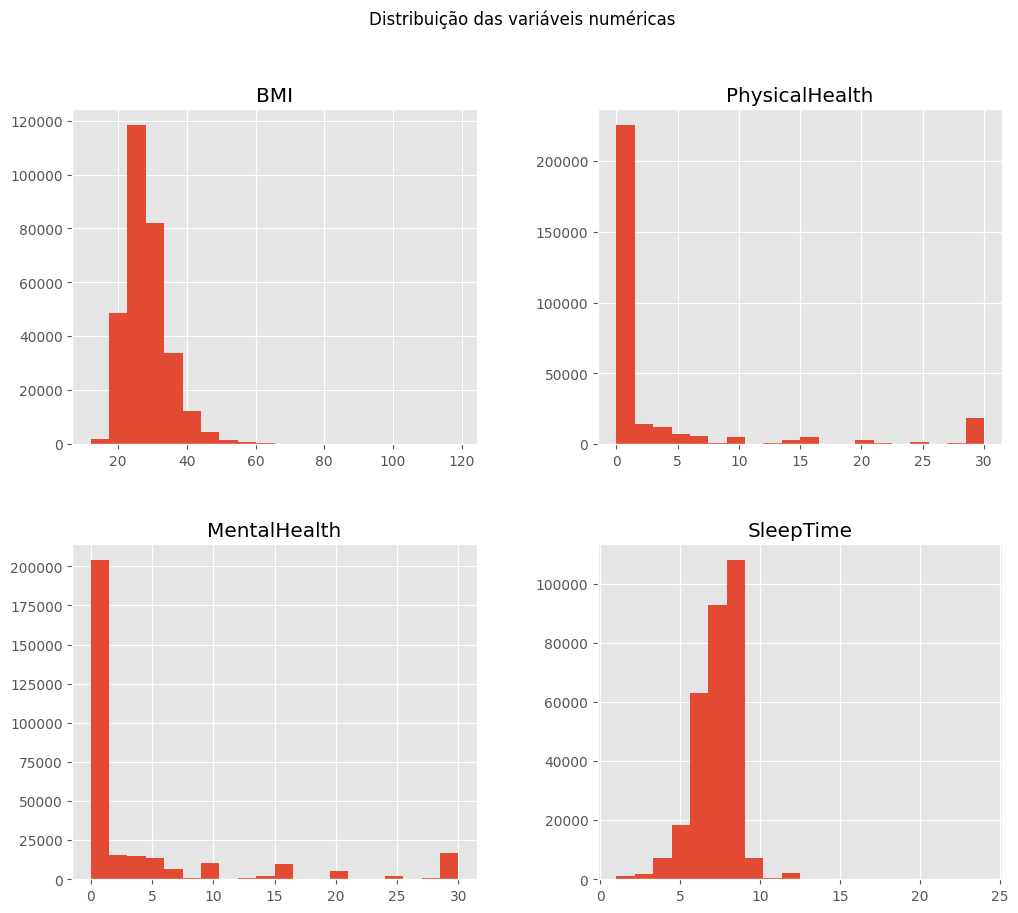

In [81]:
# ---- Histogramas das variáveis numéricas ----
df.hist(bins=20, figsize=(12,10))
plt.suptitle("Distribuição das variáveis numéricas")
plt.show()

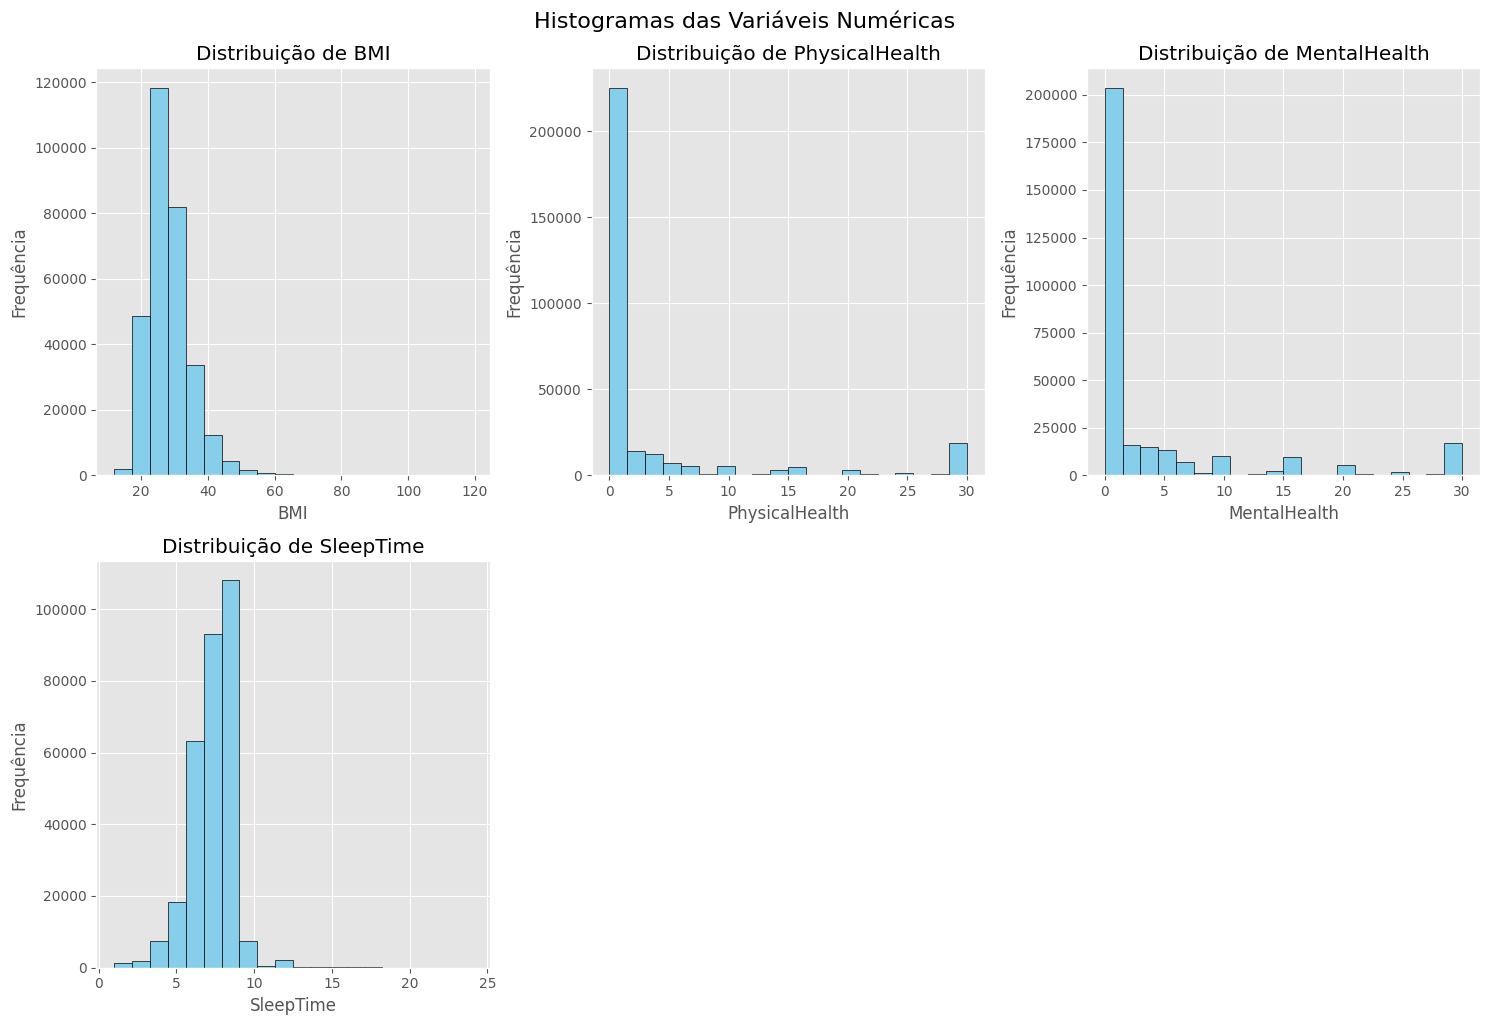

In [82]:
import matplotlib.pyplot as plt

# Seleciona apenas as colunas numéricas
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Configura a figura
fig, axes = plt.subplots(nrows=len(num_cols)//3 + 1, ncols=3, figsize=(15, 5 * (len(num_cols)//3 + 1)))
axes = axes.flatten()

# Loop para plotar cada coluna
for i, col in enumerate(num_cols):
    axes[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribuição de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')

# Remove subplots extras vazios
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Histogramas das Variáveis Numéricas", fontsize=16, y=1.02)
plt.show()


**Gráfico de Densidade**

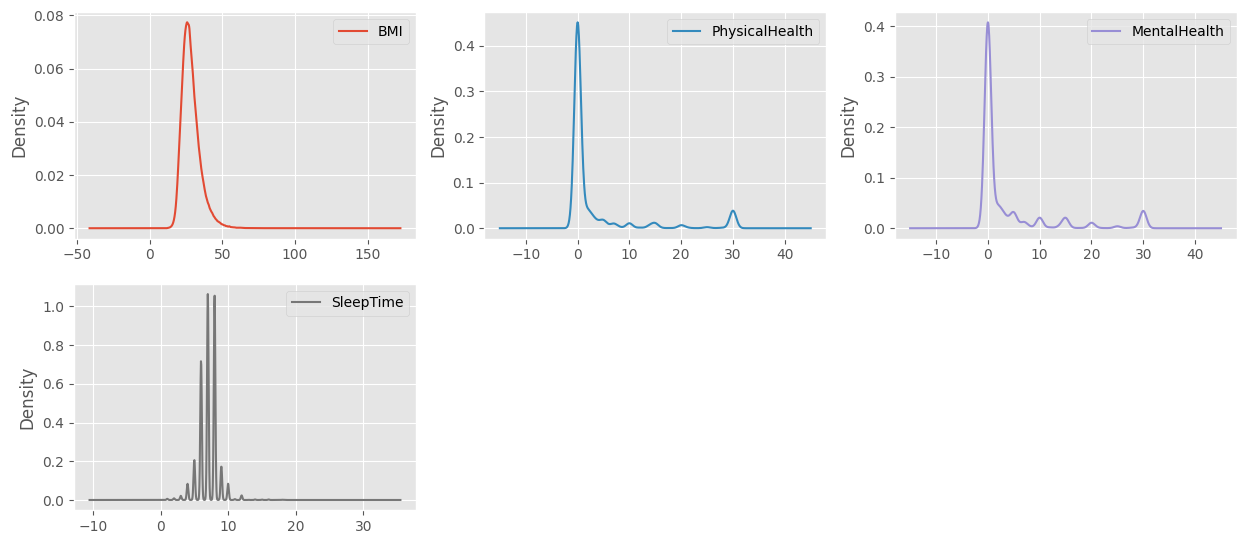

In [83]:
df.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10))
plt.show()

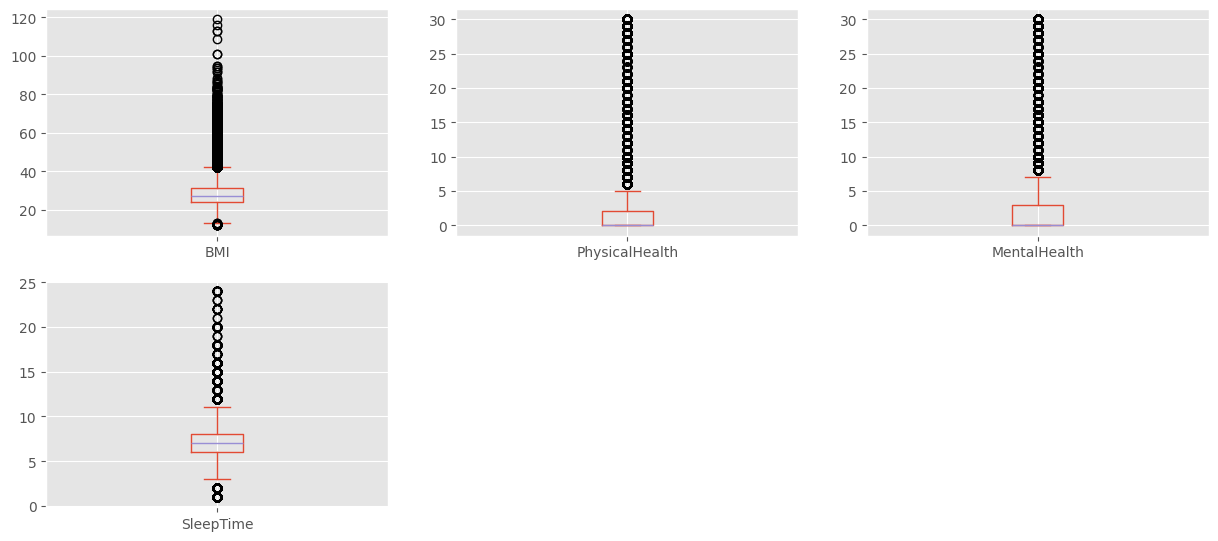

In [84]:
# Boxplot
df.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

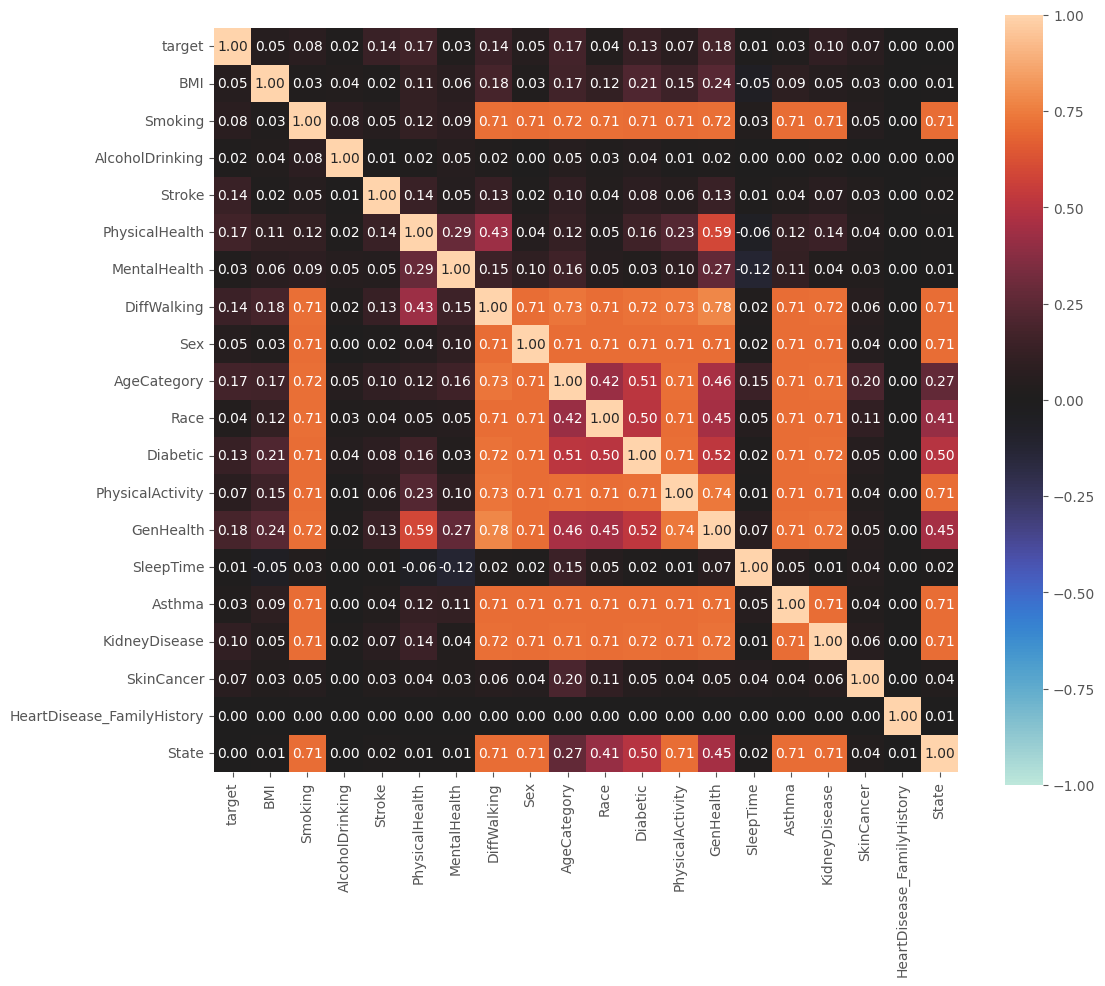

In [85]:
# ---- Associações mistas (numéricas e categóricas) ----
associations(df, figsize=(12, 10))
plt.show()

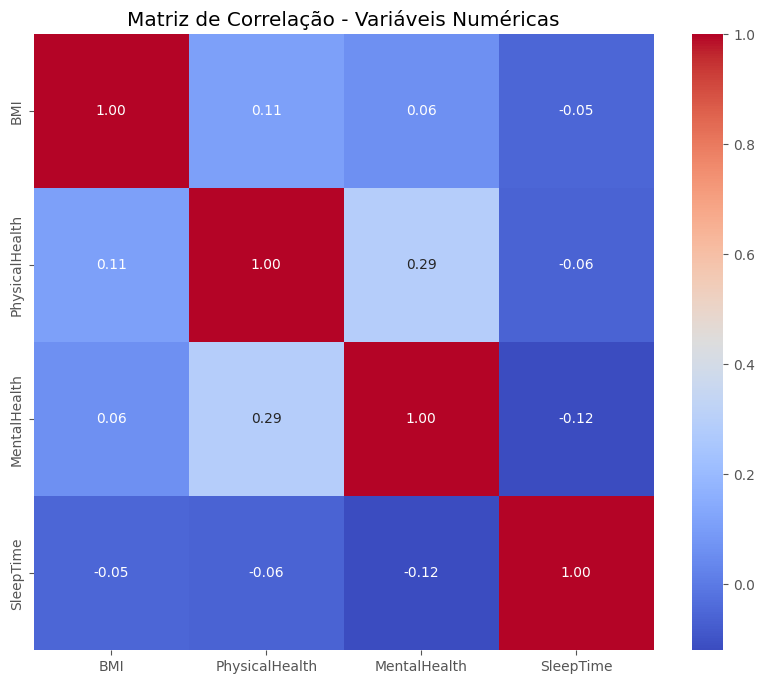

In [86]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=['int64','float64']).corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação - Variáveis Numéricas")
plt.show()


**scatter plot)**

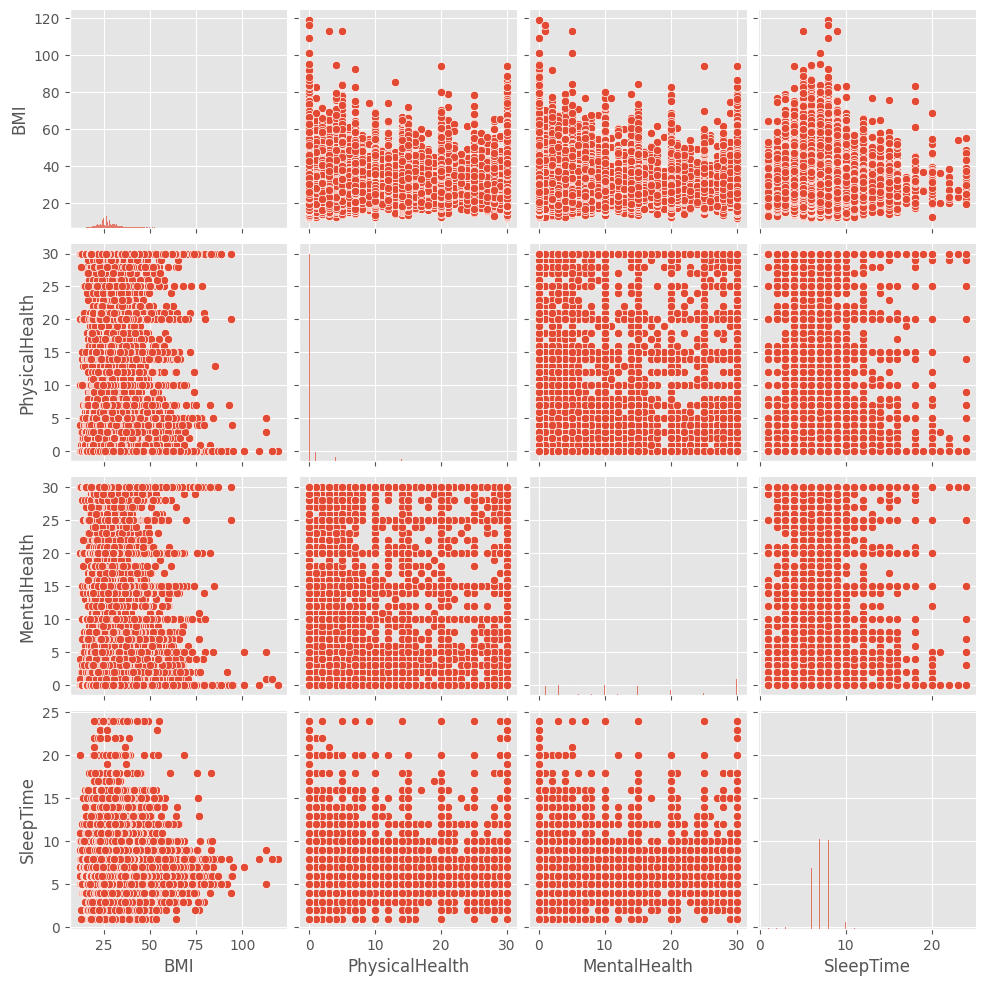

In [87]:
sns.pairplot(df)


 Descritivas estatísticas do conjunto de dados

#### variaveis categoricas

In [88]:
df.describe(include=['object']).T

,count,unique,top,freq
target,303943,2,No,277994
Smoking,303944,3,No,178669
AlcoholDrinking,202440,2,No,181686
Stroke,302875,2,No,291496
DiffWalking,303943,2,No,261966
Sex,303943,2,Female,159041
AgeCategory,303943,14,65-69,32330
Race,303943,6,White,234439
Diabetic,303943,4,No,256534
PhysicalActivity,303943,2,Yes,235894


In [89]:
for index in df.select_dtypes(include = "object"):
    print(f"{index}")
    print(df[index].unique())
    print('\n')

target
['No' 'Yes' nan]


Smoking
['No' 'Yes' 'LA']


AlcoholDrinking
['No' nan 'Yes']


Stroke
['No' 'Yes' nan]


DiffWalking
['Yes' 'No' nan]


Sex
['Female' 'Male' nan]


AgeCategory
['35-39' '70-74' '80 or older' '18-24' '55-59' '60-64' '50-54' '40-44'
 '65-69' '30-34' '45-49' '75-79' '25-29' '0' nan]


Race
['White' 'Hispanic' 'American Indian/Alaskan Native' 'Other' 'Asian'
 'Black' nan]


Diabetic
['No' 'Yes' 'No, borderline diabetes' 'Yes (during pregnancy)' nan]


PhysicalActivity
['No' 'Yes' nan]


GenHealth
['Poor' 'Excellent' 'Good' 'Very good' 'Fair' nan]


Asthma
['No' 'Yes' nan]


KidneyDisease
['No' 'Yes' nan]


SkinCancer
['No' 'Yes' nan]


HeartDisease_FamilyHistory
[nan 'No' 'Yes']


State
['TX' 'AK' 'SC' 'AZ' 'NH' 'LA' 'CA' 'NJ' 'UT' 'IA' 'NM' 'MI' 'KS' 'MT'
 'PA' 'OK' 'NC' 'MA' 'MN' 'OR' 'VA' 'MD' 'MO' 'HI' 'MS' 'IN' 'AL' 'RI'
 'GA' 'DE' 'DC' 'CO' 'WI' 'SD' 'CT' 'AR' 'ND' 'WA' 'NY' 'IL' 'VT' 'ID'
 'NE' 'TN' 'KY' 'FL' 'OH' 'NV' 'ME' 'WY' 'WV' nan 'CO ']




#### variaveis não categoricas

In [90]:
df.select_dtypes(include=['number']).describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,"303,943.00",28.32,6.37,12.02,24.03,27.32,31.38,119.00
PhysicalHealth,"303,943.00",3.36,7.94,0.00,0.00,0.00,2.00,30.00
MentalHealth,"303,943.00",3.90,7.96,0.00,0.00,0.00,3.00,30.00
SleepTime,"303,943.00",7.10,1.43,1.00,6.00,7.00,8.00,24.00


In [91]:
for index in df.select_dtypes(include = "number"):
    print(f"{index}")
    print(df[index].unique())
    print('\n')

BMI
[57.02 26.43 27.63 ... 46.05 40.7  62.42]


PhysicalHealth
[30.  0.  7.  3. 15. 10.  1.  2. 28.  4. 14. 18.  6. 20.  8.  9.  5. 25.
 13. 21. 17. 12. 24. 29. 16. 27. 23. 22. 11. 26. 19. nan]


MentalHealth
[30. 15.  0.  2.  3. 20. 10.  6.  1.  5.  7.  8. 14.  4. 29. 25. 13. 28.
 12. 18. 24. 21. 26. 27. 22.  9. 17. 16. 23. 11. 19. nan]


SleepTime
[ 9.  6.  8.  7. 10.  5.  2.  1. 12.  4.  3. 16. 11. 14. 15. 13. 18. 17.
 24. 20. 19. 21. 22. nan 23.]




Número de valores **nulos**

In [92]:
df.select_dtypes(include=['number']).isnull().sum()

,0
BMI,1
PhysicalHealth,1
MentalHealth,1
SleepTime,1


In [93]:
df.select_dtypes(include=['object']).isnull().sum()

,0
target,1
Smoking,0
AlcoholDrinking,101504
Stroke,1069
DiffWalking,1
Sex,1
AgeCategory,1
Race,1
Diabetic,1
PhysicalActivity,1




**Distribuição/Intervalo de Valores Alvo**

In [94]:
df[['target']].head()

,target
0,No
1,Yes
2,No
3,No
4,No


In [95]:
# Acessar a coluna 'HeartDisease'
coluna_heart_disease = df['target']
print("Coluna target:")
print(coluna_heart_disease)

Coluna target:
0          No
1         Yes
2          No
3          No
4          No
         ... 
303939     No
303940    Yes
303941     No
303942     No
303943     No
Name: target, Length: 303944, dtype: object


In [96]:
print('This is a Series')
print(type(df['target']))
df['target'].head()

This is a Series
<class 'pandas.core.series.Series'>


,target
0,No
1,Yes
2,No
3,No
4,No


In [97]:
df['target'].value_counts(dropna=False)

,count
target,
No,277994
Yes,25949
NaN,1


<Axes: xlabel='target', ylabel='count'>

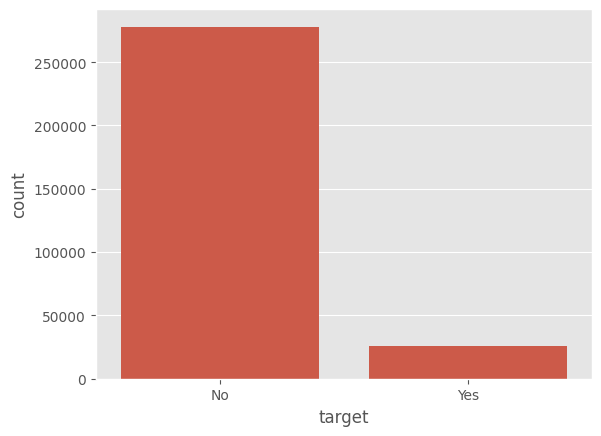

In [98]:
sns.countplot(data=df, x='target')

A variavel Target possui dois valors e um nulo

HeartDisease = "Yes"

HeartDisease = "No"

**Obs:**
Como foi encontrado um valor NaN a opção mais comum é remover as linhas com NaN na target, porque sem o valor correto não tem como treinar o modelo (nem validar a previsão).

In [99]:
df = df.dropna(subset=["target"])

In [100]:
df['target'].value_counts(dropna=False)

,count
target,
No,277994
Yes,25949


Como noasa variavel Target é categorica, para faciitar o estudo irei transformar em não categoria variando os valores entre 0 e 1

HeartDisease = "Yes" => tem chance de ter problemas cardiacos será 1

HeartDisease = "No" => Não tem chance de ter problemas cardiacos será 0

In [101]:
df['target'] = df['target'].replace({'No':0,'Yes':1})

/tmp/ipython-input-194850831.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-194850831.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [102]:
# Acessar a coluna 'HeartDisease'
coluna_target = df['target']
print("Coluna target:")
print(coluna_target)

Coluna target:
0         0
1         1
2         0
3         0
4         0
         ..
303939    0
303940    1
303941    0
303942    0
303943    0
Name: target, Length: 303943, dtype: int64


In [103]:
### Alternativamente
(df['target'] == 1)

,target
0,False
1,True
2,False
3,False
4,False
...,...
303939,False
303940,True
303941,False
303942,False


In [104]:
# retorna o total de linhas
df['target'].count()

np.int64(303943)

In [105]:
#  retorma a soma
df['target'].sum()

np.int64(25949)

In [106]:
# retorna a media
df['target'].mean()

np.float64(0.08537456036164676)

Distribuição de variáveis ​​e relações com o Target

* Variavel BMI

para ver a relação e distribuição da variavel com o Targer



In [107]:
print("BMI")
print(df['BMI'].unique())
print('\n')

BMI
[57.02 26.43 27.63 ... 46.05 40.7  62.42]




**Histograma da BMI**

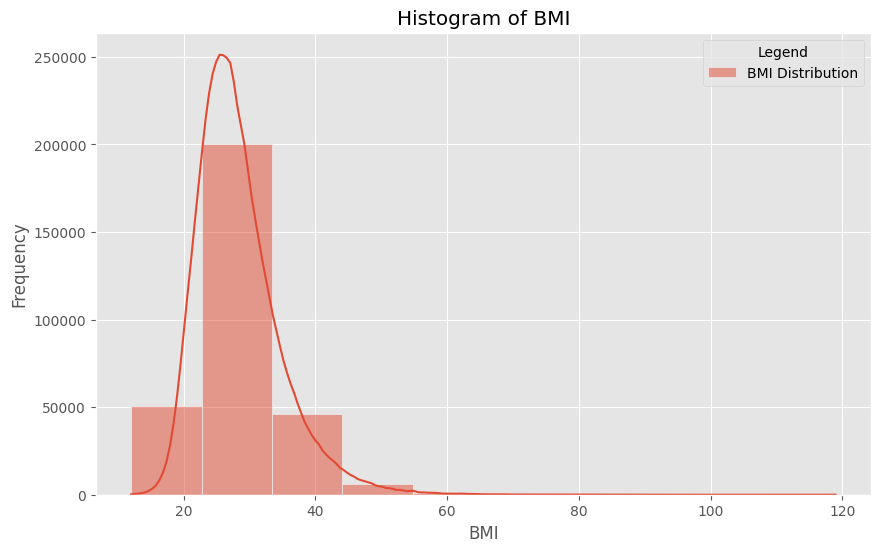

In [108]:
# Plotar o histograma usando Matplotlib
plt.figure(figsize=(10, 6))
sns.histplot(df['BMI'], bins=10, kde=True, label='BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Histogram of BMI')
plt.legend(title='Legend')  # Adiciona uma legenda com título
plt.show()

#### Este gráfico evidencia que a maior parte da amostra se concentra em valores de IMC entre 20 e 40, indicando que a maioria dos indivíduos analisados encontra-se em condição de sobrepeso ou obesidade. Além disso, observa-se que justamente nessas faixas o risco de desenvolver doenças cardíacas tende a ser mais elevado, reforçando a relação entre excesso de peso e maior probabilidade de problemas cardiovasculares.

**Distribuição dos valores dos valores de BMI entre os indivíduos no seu conjunto de dados**

In [109]:
df_bmi = df[['BMI','target']].groupby(['BMI']).mean()

In [110]:
df_bmi.head()

,target
BMI,
12.02,0.00
12.13,0.00
12.16,0.00
12.20,0.00
12.21,1.00


In [111]:
df_bmi

,target
BMI,
12.02,0.00
12.13,0.00
12.16,0.00
12.20,0.00
12.21,1.00
...,...
101.00,0.00
109.00,0.00
113.00,0.50


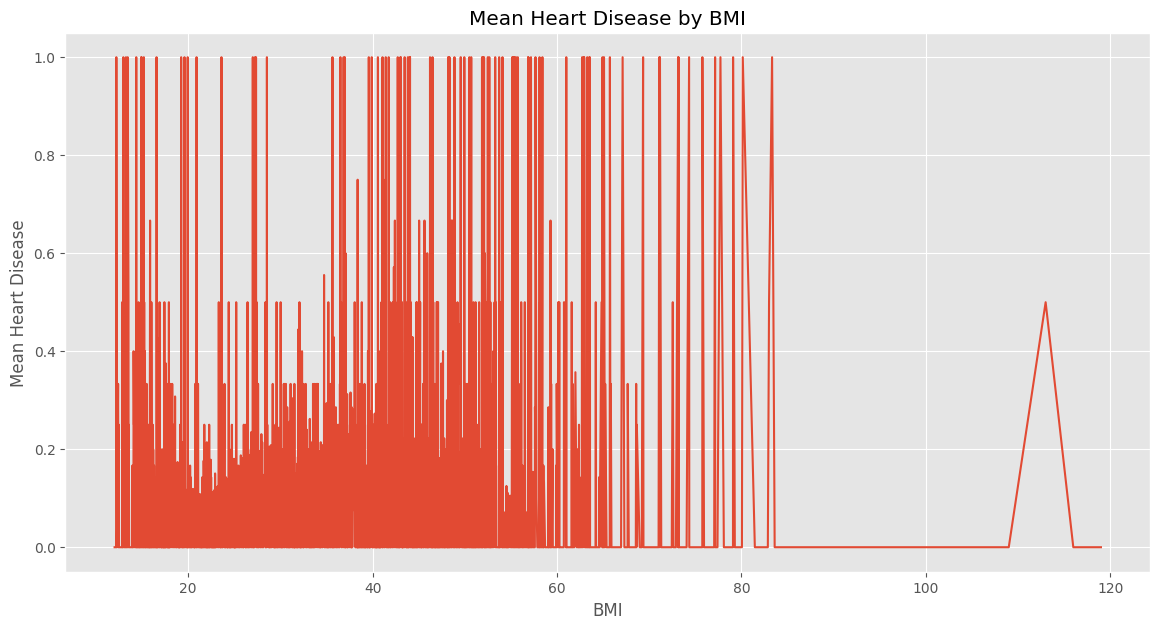

In [112]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_bmi, x='BMI', y='target')
plt.xlabel('BMI')
plt.ylabel('Mean Heart Disease')
plt.title('Mean Heart Disease by BMI')
plt.show()

#### Neste gráfico, observa-se que a média de pessoas com maior incidência de doenças cardíacas está concentrada justamente na faixa que, anteriormente, já havia se destacado pela maior frequência da amostra: indivíduos em situação de sobrepeso ou obesidade. Além disso, nota-se a presença de alguns valores destoantes, provavelmente resultantes de erros de registro ou inconsistências na base de dados, já que representam medidas que seriam inviáveis de serem alcançadas na prática

**Analise**

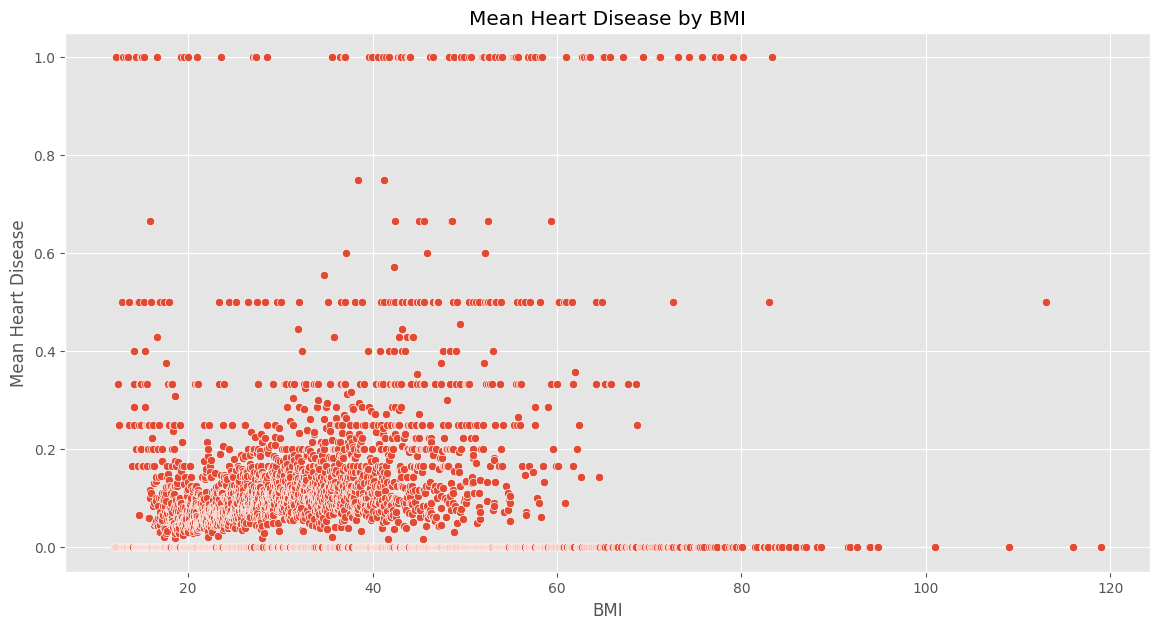

In [113]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_bmi, x='BMI', y='target')
plt.xlabel('BMI')
plt.ylabel('Mean Heart Disease')
plt.title('Mean Heart Disease by BMI')
plt.show()

**Calculando a medias por faixa etaria  de ter problemas cardiaco**

In [114]:
df_agecategory = df.groupby('AgeCategory')['target'].mean().reset_index()

In [115]:
print(df_agecategory)

    AgeCategory  target
0             0    0.08
1         18-24    0.01
2         25-29    0.01
3         30-34    0.01
4         35-39    0.01
5         40-44    0.02
6         45-49    0.03
7         50-54    0.05
8         55-59    0.07
9         60-64    0.10
10        65-69    0.12
11        70-74    0.16
12        75-79    0.19
13  80 or older    0.23


In [116]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [117]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [118]:
data_table.DataTable(df_agecategory, include_index=False, num_rows_per_page=10)

,AgeCategory,target
0,0,0.08
1,18-24,0.01
2,25-29,0.01
3,30-34,0.01
4,35-39,0.01
5,40-44,0.02
6,45-49,0.03
7,50-54,0.05
8,55-59,0.07
9,60-64,0.10


/tmp/ipython-input-212689857.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




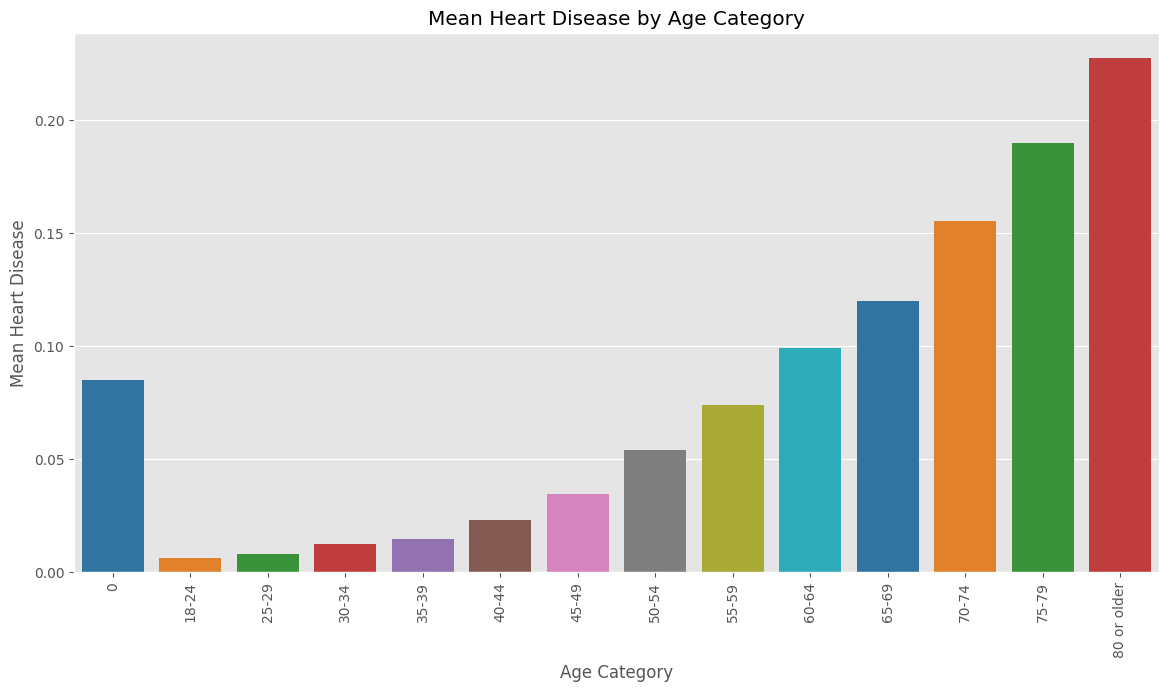

In [119]:
plt.figure(figsize=(14, 7))

# Criar uma paleta com cores diferentes para cada barra
palette = sns.color_palette("tab10", n_colors=len(df_agecategory))

sns.barplot(
    data=df_agecategory,
    x='AgeCategory',
    y='target',
    palette=palette
)

plt.xlabel('Age Category')
plt.ylabel('Mean Heart Disease')
plt.title('Mean Heart Disease by Age Category')
plt.xticks(rotation=90)
plt.show()

##### Pela media podemos afirmar que com o aumento da idade temos mais probabilidade de ter doenças cardiacas. Visualmente podemos observar que  depois deis 50 o Risco tem um aumento siginificativo.

**Calculando a media por faixa etaria, sexo e ter ou nao Problemas cardiacos**

In [120]:
df_sex_agecategory = df[['AgeCategory', 'Sex', 'target']].groupby(['AgeCategory', 'Sex']).mean().reset_index()

In [121]:
print(df_sex_agecategory)

    AgeCategory     Sex  target
0             0  Female    0.03
1             0    Male    0.15
2         18-24  Female    0.01
3         18-24    Male    0.01
4         25-29  Female    0.01
5         25-29    Male    0.01
6         30-34  Female    0.01
7         30-34    Male    0.01
8         35-39  Female    0.01
9         35-39    Male    0.01
10        40-44  Female    0.02
11        40-44    Male    0.02
12        45-49  Female    0.03
13        45-49    Male    0.04
14        50-54  Female    0.04
15        50-54    Male    0.06
16        55-59  Female    0.06
17        55-59    Male    0.09
18        60-64  Female    0.07
19        60-64    Male    0.13
20        65-69  Female    0.08
21        65-69    Male    0.16
22        70-74  Female    0.11
23        70-74    Male    0.22
24        75-79  Female    0.14
25        75-79    Male    0.26
26  80 or older  Female    0.18
27  80 or older    Male    0.30


In [122]:
data_table.DataTable(df_sex_agecategory, include_index=False, num_rows_per_page=30)

,AgeCategory,Sex,target
0,0,Female,0.03
1,0,Male,0.15
2,18-24,Female,0.01
3,18-24,Male,0.01
4,25-29,Female,0.01
5,25-29,Male,0.01
6,30-34,Female,0.01
7,30-34,Male,0.01
8,35-39,Female,0.01
9,35-39,Male,0.01


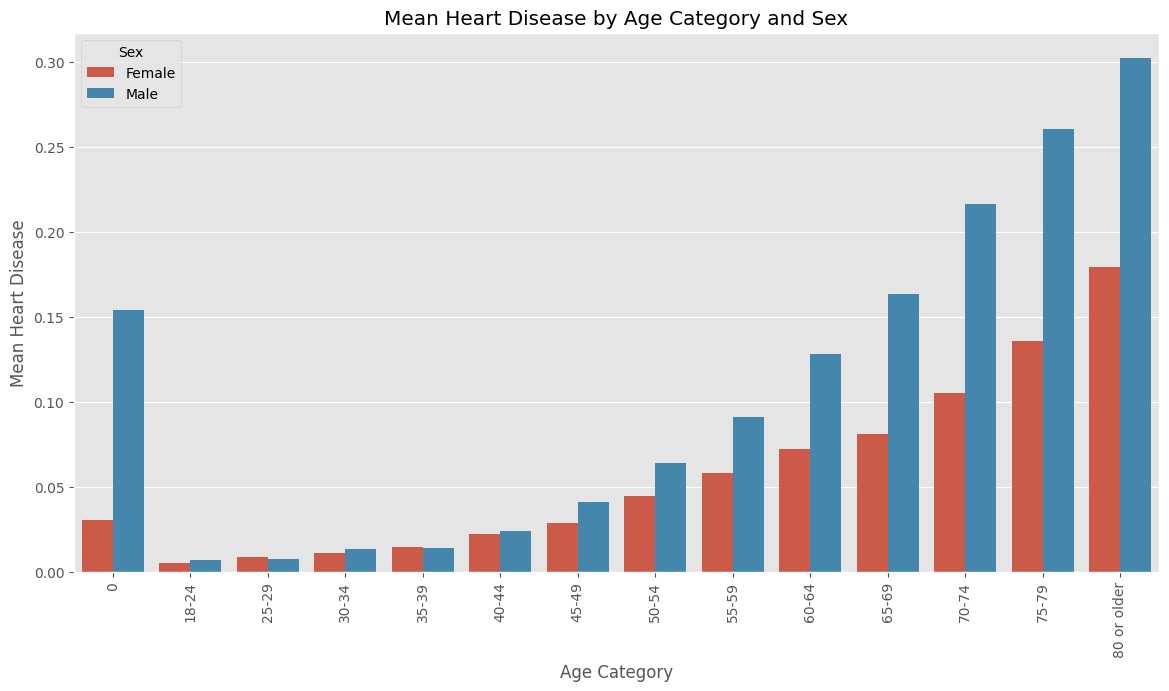

In [123]:
plt.figure(figsize=(14, 7))
sns.barplot(data=df_sex_agecategory, x='AgeCategory', y='target', hue='Sex')
plt.xlabel('Age Category')
plt.ylabel('Mean Heart Disease')
plt.title('Mean Heart Disease by Age Category and Sex')
plt.xticks(rotation=90)
plt.show()

Podemos observar que os homens possuem uma maior probabilidade de ter doenças cardiacas independendente da idade e que a partir da faixa de 45 -49 o risco aumenta muito

In [124]:
df_sex_agecategory.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Columns: 3 entries, AgeCategory to target
dtypes: float64(1), object(2)
memory usage: 804.0+ bytes


In [125]:
df_agecategory.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Columns: 2 entries, AgeCategory to target
dtypes: float64(1), object(1)
memory usage: 356.0+ bytes


<Axes: >

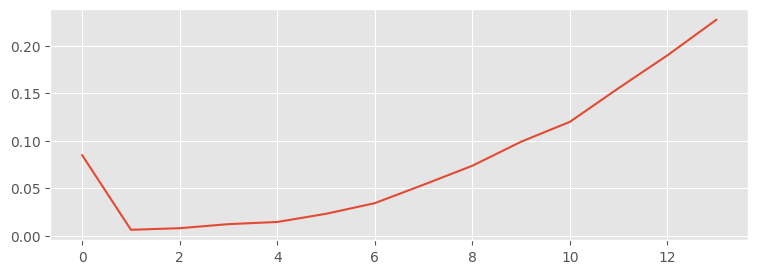

In [126]:
plt.figure(figsize=[9,3])
df_agecategory['target'].plot()

Verificamos conforme o aumento da idade temos mais risco de ter Doença cardíaca

#### Variavel  Race

Usaremos o histograma para distribuição da variação em relação a raça e como é uma variavel categorica irei transformar em não categorica

In [127]:
df['Race'].head()

,Race
0,White
1,White
2,White
3,White
4,White


In [128]:
valores_distintos = df['Race'].unique()
print(valores_distintos)

['White' 'Hispanic' 'American Indian/Alaskan Native' 'Other' 'Asian'
 'Black' nan]


In [129]:
df['Race'].isnull()

,Race
0,False
1,False
2,False
3,False
4,False
...,...
303939,False
303940,False
303941,False
303942,False


In [130]:
df["Race"].isnull().sum()

np.int64(1)

In [133]:
df.loc[:, "Race"] = (
    df["Race"]
    .replace({
        "White": 0,
        "Black": 1,
        "Asian": 2,
        "American Indian/Alaskan Native": 3,
        "Other": 4,
        "Hispanic": 5,
        "nan": -1
    })
    .fillna(-1)  # cobre NaN reais
    .astype("int8")  # converte para numérico compacto
)



In [134]:
df['Race'].head()

,Race
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00


In [ ]:
valores_distintos = df['Race'].unique()


In [ ]:
df_race = df[['Race','target']].groupby(['Race']).count()
print(df_race)

      target
Race        
0.00  234438
1.00   20919
2.00    7515
3.00    4737
4.00   10323
5.00   26010


<Axes: ylabel='Frequency'>

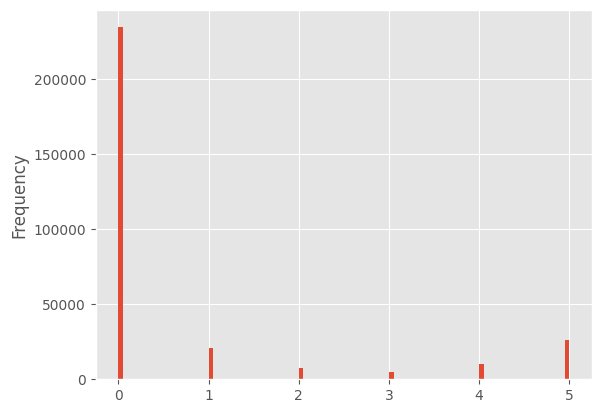

In [ ]:
df['Race'].plot(kind='hist', bins = 100)

##### Verificamos que a raça não é uma opção boa para analise pois notamos que a nossa amostragem e composta de sua maioria da raça branca. Logo, poderemos ver uma certa tendencica a informar que a raça branca terá maior probabilidade de ter doenças cardiácas

**Calculando a media por Raca**

In [63]:
df['Race'].value_counts()

,count
Race,
0.00,234438
5.00,26010
1.00,20919
4.00,10323
2.00,7515
3.00,4737


In [ ]:
df['Race'].value_counts(normalize=True) * 100

,proportion
Race,
0.00,77.13
5.00,8.56
1.00,6.88
4.00,3.40
2.00,2.47
3.00,1.56


In [ ]:
df.groupby('Race')['target'].mean()


,target
Race,
0.00,0.09
1.00,0.08
2.00,0.03
3.00,0.10
4.00,0.08
5.00,0.05


/tmp/ipython-input-901915363.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




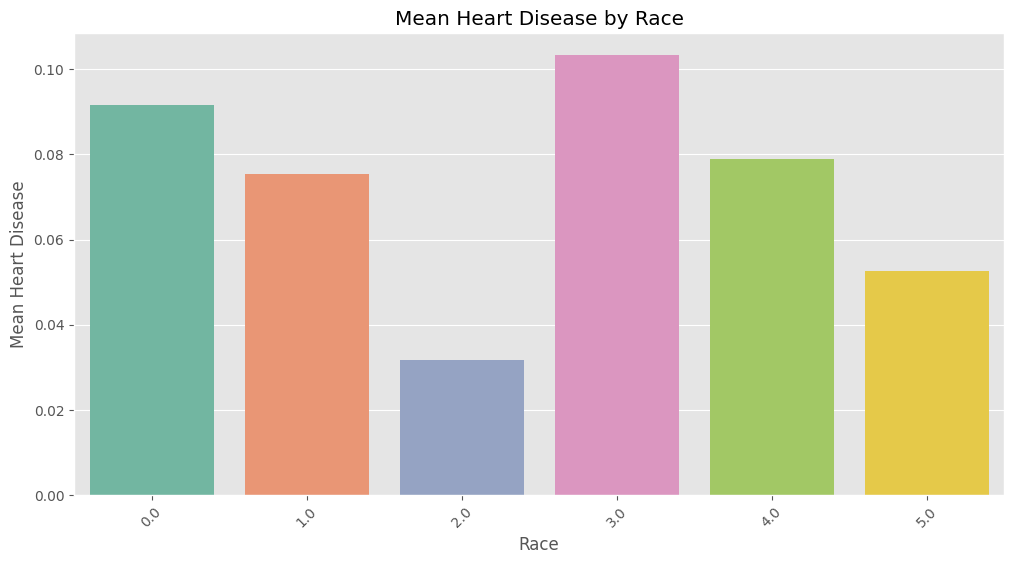

In [ ]:
# Calcular média de HeartDisease por raça
race_mean = df.groupby('Race')['target'].mean().reset_index()

# Criar paleta de cores (uma para cada raça)
palette = sns.color_palette("Set2", n_colors=len(race_mean))

# Plotar gráfico de barras
plt.figure(figsize=(12,6))
sns.barplot(data=race_mean, x='Race', y='target', palette=palette)
plt.xlabel('Race')
plt.ylabel('Mean Heart Disease')
plt.title('Mean Heart Disease by Race')
plt.xticks(rotation=45)
plt.show()

Pelo gráfico histograma de Raça.

*  Podemos notar que a maior frequÊncia da raça é a Branca
*  Asiáticos demonstram menor probabilidade de ter doenças cardiacas enquanto os nativos americanos apresentam a maior



**Relação da Raca/ BMI e HeartDisease**

In [ ]:
# Calculando médias por raça
mean_values_by_race = df.groupby('Race').agg({
    'BMI': 'mean',
    'target': 'mean'
}).reset_index()

print(mean_values_by_race)

   Race   BMI  target
0  0.00 28.16    0.09
1  1.00 30.11    0.08
2  2.00 25.22    0.03
3  3.00 29.69    0.10
4  4.00 28.76    0.08
5  5.00 28.79    0.05


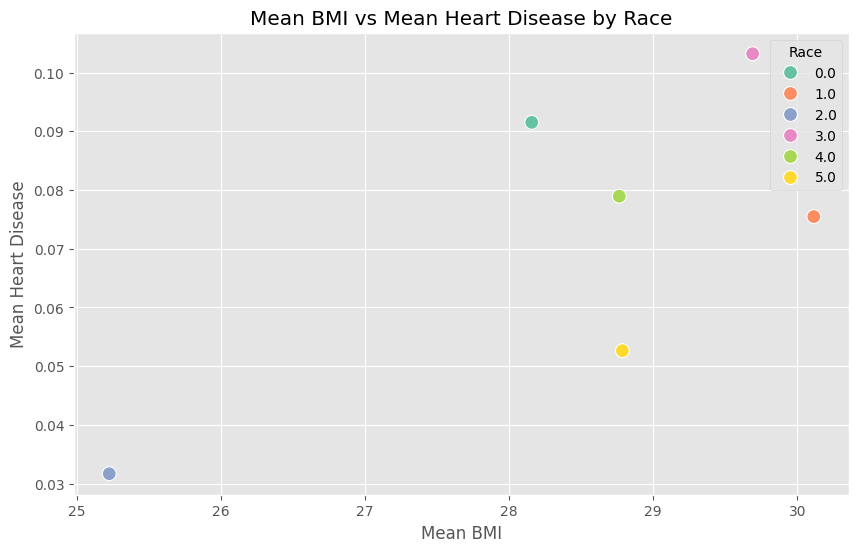

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mean_values_by_race, x='BMI', y='target', hue='Race', palette='Set2', s=100)
plt.xlabel('Mean BMI')
plt.ylabel('Mean Heart Disease')
plt.title('Mean BMI vs Mean Heart Disease by Race')
plt.show()

/tmp/ipython-input-1467983782.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1467983782.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




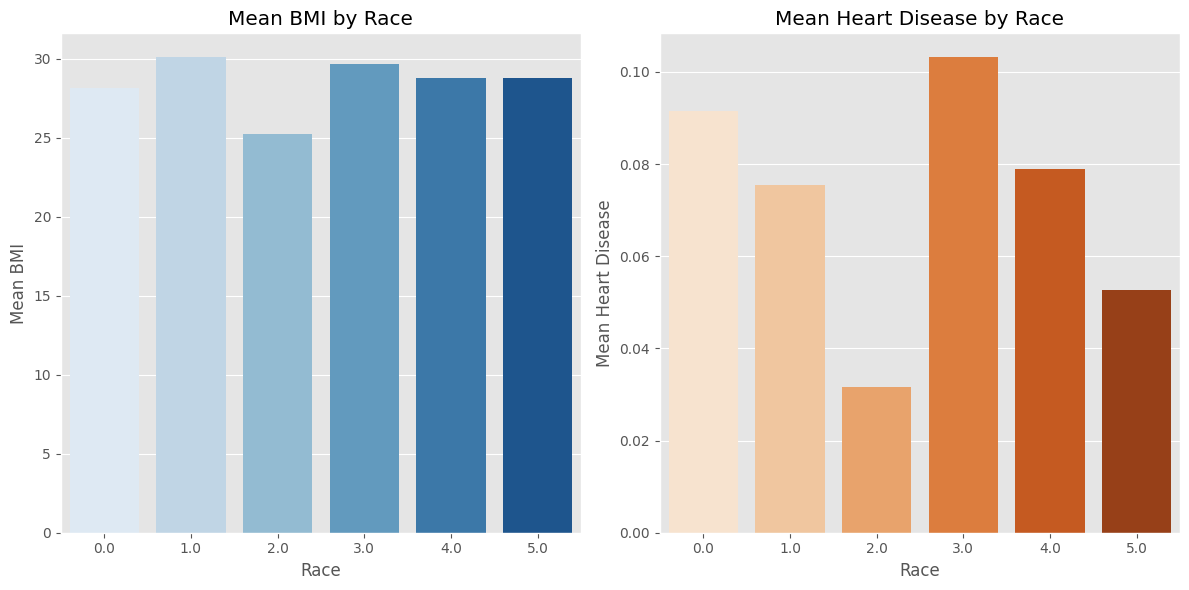

In [ ]:
plt.figure(figsize=(12, 6))

# Plotagem de BMI
plt.subplot(1, 2, 1)
sns.barplot(data=mean_values_by_race, x='Race', y='BMI', palette='Blues')
plt.xlabel('Race')
plt.ylabel('Mean BMI')
plt.title('Mean BMI by Race')

# Plotagem de HeartDisease
plt.subplot(1, 2, 2)
sns.barplot(data=mean_values_by_race, x='Race', y='target', palette='Oranges')
plt.xlabel('Race')
plt.ylabel('Mean Heart Disease')
plt.title('Mean Heart Disease by Race')

plt.tight_layout()
plt.show()

Ao comparar o IMC (BMI) entre as diferentes raças, observa-se que os valores apresentam diferenças entre os grupos. Por outro lado, as probabilidades de desenvolver doenças cardíacas apresentam variações mais significativas, sugerindo que o IMC tem uma correlação maior com o risco de doenças cardíacas neste conjunto de dados do que a Raça.

Variavel MentalHealth

Analise para MentalHealth

In [ ]:
df['MentalHealth'].head()

,MentalHealth
0,30.00
1,15.00
2,0.00
3,0.00
4,0.00


<Axes: ylabel='Frequency'>

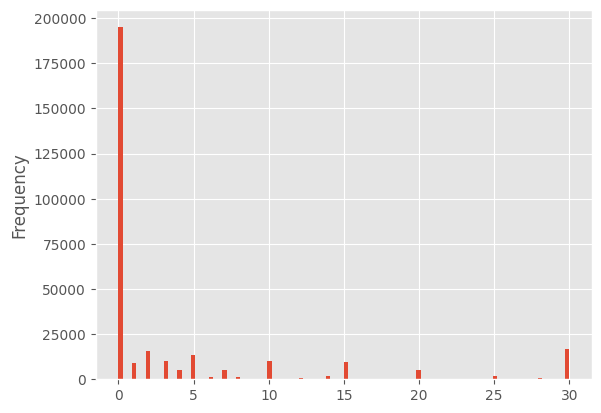

In [ ]:
df['MentalHealth'].plot(kind='hist', bins = 100)

In [ ]:
# Calcular a média de MentalHealth por HeartDisease
mean_mental_health_by_heart_disease = df.groupby('target')['MentalHealth'].mean().reset_index()
print(mean_mental_health_by_heart_disease)

   target  MentalHealth
0       0          3.84
1       1          4.65


/tmp/ipython-input-1071520102.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




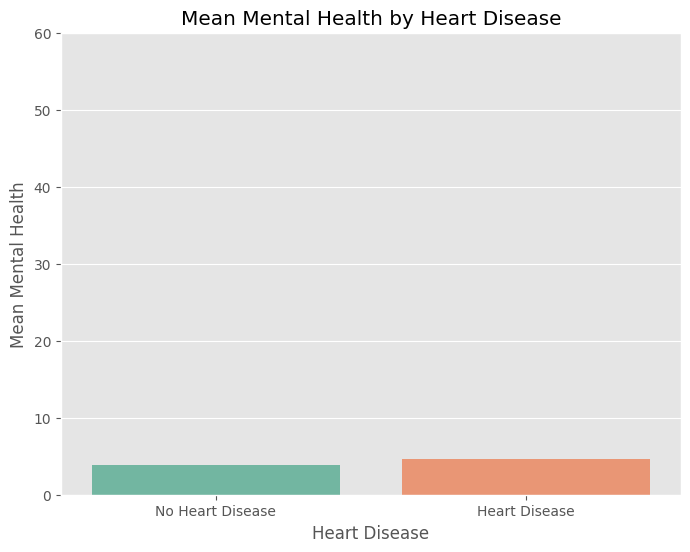

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=mean_mental_health_by_heart_disease, x='target', y='MentalHealth', palette='Set2')
plt.xlabel('Heart Disease')
plt.ylabel('Mean Mental Health')
plt.title('Mean Mental Health by Heart Disease')
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease'])
plt.ylim(0, 60)  # Ajustar limite do eixo y se necessário
plt.show()

##### Notamos que as pessoas que possuem uma saude metal possuem uma pequena diferença em não ter problemas cardiacos, essa relação sozinha mostra que não é o unico fator a ser considerado

**Analise da variavel diabete, para isso terei que transformar a variavel em não categorica**

In [ ]:
df['Diabetic'] = df['Diabetic'].replace({'No':0,
                                         'No, borderline diabetes':0,
                                         'Yes':1,
                                         'Yes (during pregnancy)':1})

/tmp/ipython-input-1631110486.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-1631110486.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df['Diabetic'].head()

,Diabetic
0,0.00
1,1.00
2,0.00
3,0.00
4,0.00


<Axes: ylabel='Frequency'>

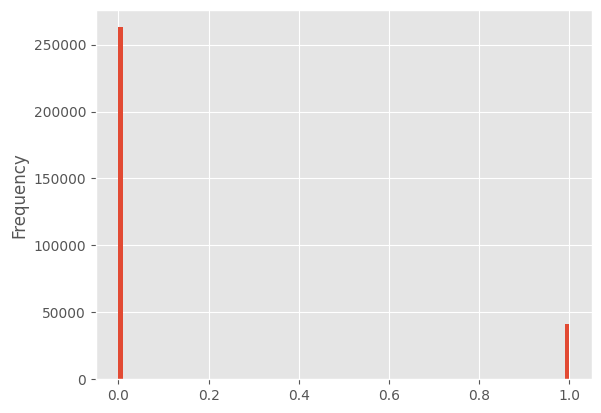

In [ ]:
df['Diabetic'].plot(kind='hist', bins = 100)

In [ ]:
df_diabetic = df[['Diabetic', 'target']].groupby(['Diabetic']).mean().reset_index()

In [ ]:
data_table.DataTable(df_diabetic, include_index=False, num_rows_per_page=10)

,Diabetic,target
0,0.00,0.07
1,1.00,0.21


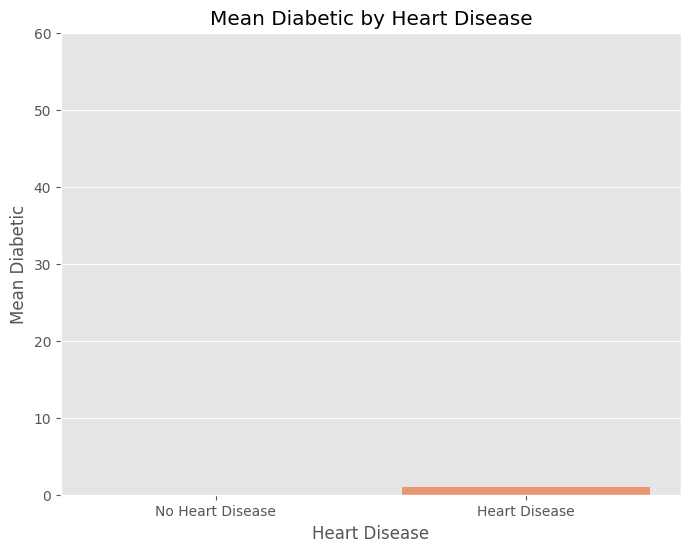

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df_diabetic, x='target', y='Diabetic', hue='target', palette='Set2')
plt.xlabel('Heart Disease')
plt.ylabel('Mean Diabetic')
plt.title('Mean Diabetic by Heart Disease')
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease'])
plt.ylim(0, 60)
plt.legend([],[], frameon=False)  # Remove legenda se não quiser mostrar
plt.show()



Pelo grafico podemos informar que as pessoas que tem Diabete tem mais probalbilidade de ter problemas cardiacos

##### Escolhemos agora a variabe BMI - IMC

<Axes: ylabel='Frequency'>

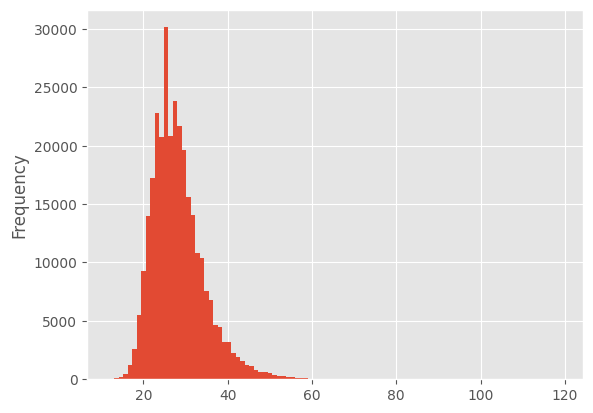

In [ ]:
df['BMI'].plot(kind='hist', bins = 100)

Podemos notar que esta variavel possui uma boa distribuição

<Axes: ylabel='BMI'>

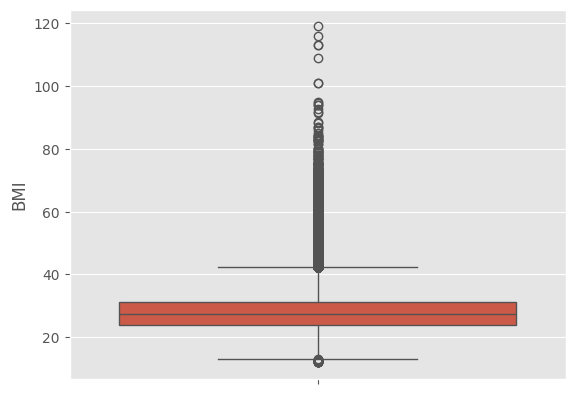

In [ ]:
## Without target
sns.boxplot(data=df, y='BMI')

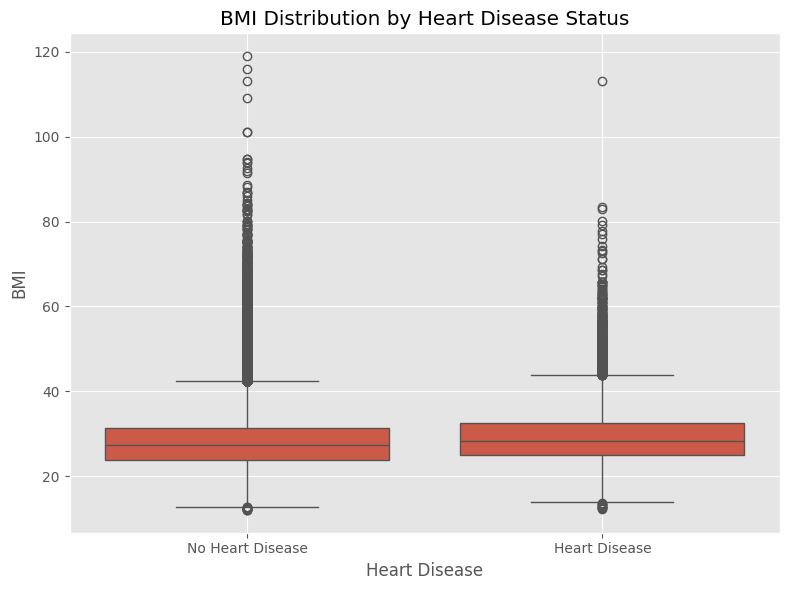

In [ ]:
# Plotar o boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='target', y='BMI')
plt.xlabel('Heart Disease')
plt.ylabel('BMI')
plt.title('BMI Distribution by Heart Disease Status')
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease'])
plt.grid(True)  # Adicionar grades ao gráfico
plt.tight_layout()  # Ajustar layout para melhor visualização
plt.show()

#### Nesse grafico nota-se uma proporcionalidade esperada na frequencia entre pessoas com e sem doença cardiacas estando presentes na mesma faixa demografica, com as com doenças cardiacas tendo uma leve proporção maior em uma faixa um pouco superior no valor do BMI

In [ ]:
df[['BMI','target']].groupby('target').describe()

BMI                                          
            count  mean  std   min   25%   50%   75%    max
target                                                     
0      277,993.00 28.22 6.33 12.02 23.88 27.26 31.32 119.00
1       25,949.00 29.41 6.61 12.21 25.06 28.34 32.61 113.00

Noto que os valores apresentados que o ICM sozinho não determinar a um risco maior de ter doenças cardiacas

**Variaveis PhysicalHealth & MentalHealth**

/tmp/ipython-input-2984764972.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




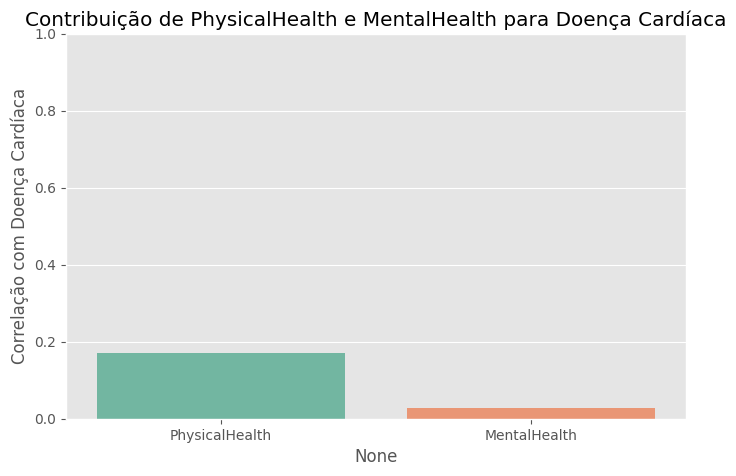

In [ ]:
# Selecionar apenas as colunas de interesse
cols = ['PhysicalHealth', 'MentalHealth', 'target']

# Calcular correlação com o target
correlations = df[cols].corr()['target'].drop('target')

# Plotar gráfico de barras
plt.figure(figsize=(8,5))
sns.barplot(x=correlations.index, y=correlations.values, palette='Set2')
plt.ylabel('Correlação com Doença Cardíaca')
plt.title('Contribuição de PhysicalHealth e MentalHealth para Doença Cardíaca')
plt.ylim(0,1)
plt.show()

<Axes: ylabel='Frequency'>

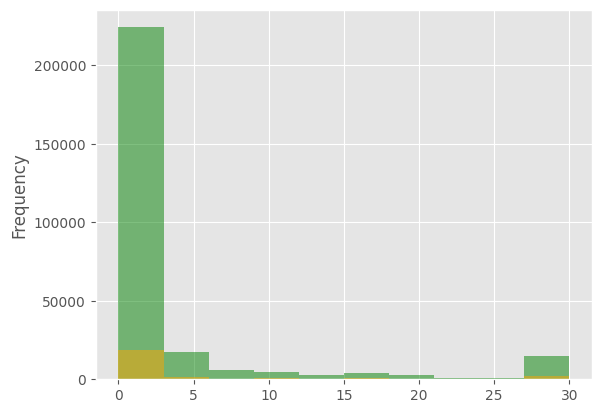

In [ ]:
df[df.target == 0]['PhysicalHealth'].plot(kind='hist', alpha=.5, color="green")
df[df.target == 1]['MentalHealth'].plot(kind='hist', alpha=.5, color="orange")

<Axes: ylabel='Frequency'>

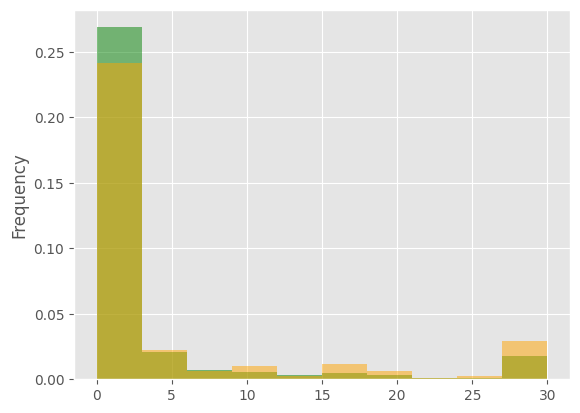

In [ ]:
df[df.target == 0]['PhysicalHealth'].plot(kind='hist', alpha=.5, color="green", density=True)
df[df.target == 1]['MentalHealth'].plot(kind='hist', alpha=.5, color="orange", density=True)

A barra mais alta indica qual variável tem maior correlação com o risco de doenças cardíacas.

Podemos observar que PhysicalHealth, significa que a saúde física tem mais impacto no risco.


###Variaveis Categoricas

**Variável Estado (State)**

<Axes: xlabel='State', ylabel='count'>

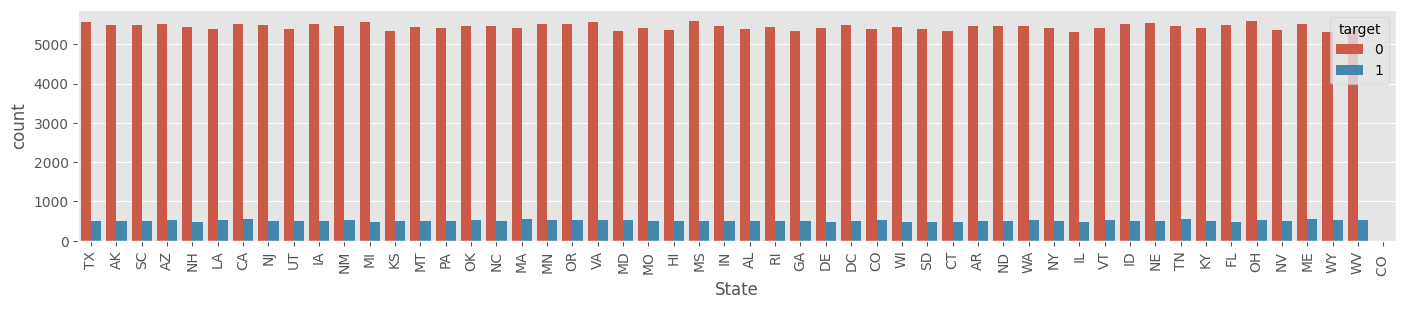

In [ ]:
plt.figure(figsize=[17,3])
plt.xticks(rotation=90)
sns.countplot(data=df, x='State', hue='target')

aqui apresenta-se a distribuição de pessoas com ou sem doenças cardiacas por estado

In [ ]:
df.pivot_table(index='State', values='target', aggfunc=[len, sum, np.mean]).sort_values(by=[('mean','target')], ascending = False)

/tmp/ipython-input-4168737511.py:1: FutureWarning:

The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.

/tmp/ipython-input-4168737511.py:1: FutureWarning:

The provided callable <function mean at 0x7d16c9170900> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



,len,sum,mean
,target,target,target
State,,,
MA,5978,554,0.09
TN,6035,557,0.09
CO,5928,536,0.09
WY,5837,524,0.09
CA,6060,544,0.09
ME,6062,541,0.09
OK,6001,535,0.09
WA,6009,535,0.09


In [ ]:
pd.crosstab(df['State'], df['target'])

target,0,1
State,,
AK,5498,510
AL,5398,494
AR,5473,510
AZ,5518,527
CA,5516,544
CO,5392,536
CO,1,0
CT,5340,476
DC,5482,502


**Variavel Asthma**

<Axes: xlabel='Asthma', ylabel='count'>

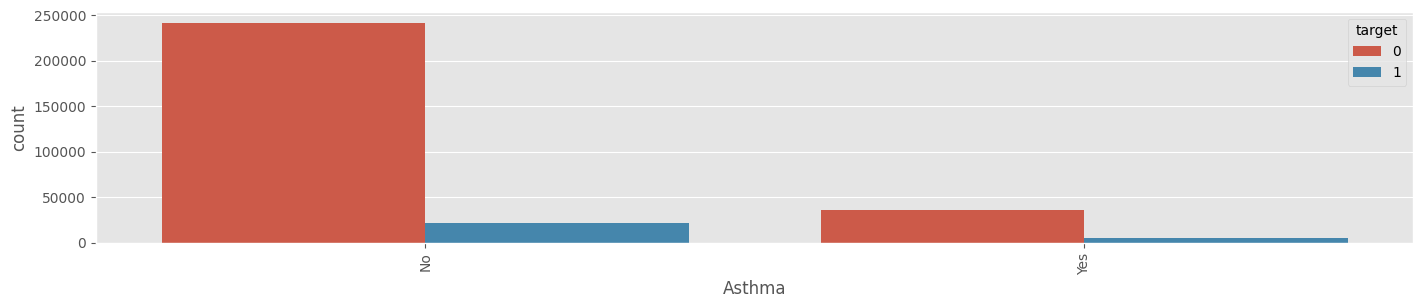

In [ ]:
plt.figure(figsize=[17,3])
plt.xticks(rotation=90)
sns.countplot(data=df, x='Asthma', hue='target')

Preliminarmente podemos avaliar que o grafico apresenta dados que nos informam que as pessoas que não tem asma são a maioria com problemas cardiacos

In [ ]:
df_asma_mean = df[['Asthma','target']].groupby(['Asthma']).mean()
print(df_asma_mean)

        target
Asthma        
No        0.08
Yes       0.11


In [ ]:
df.select_dtypes(include=['object']).isnull().sum()

,0
Smoking,0
AlcoholDrinking,101503
Stroke,1069
DiffWalking,1
Sex,1
AgeCategory,1
PhysicalActivity,1
GenHealth,1
Asthma,1
KidneyDisease,1


Colunas do DataFrame: Index(['Asthma', 'HeartDisease'], dtype='object')


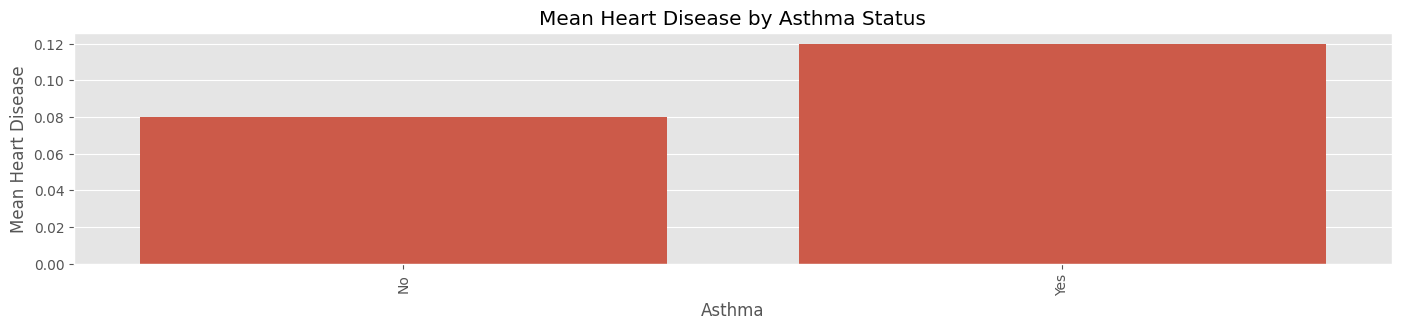

In [ ]:
# Dados originais em um formato pivot
data = {
    'Asthma': ['No', 'Yes'],
    'HeartDisease': [0.08, 0.12]
}

df_asma_mean = pd.DataFrame(data)

# Verificar as colunas do DataFrame
print("Colunas do DataFrame:", df_asma_mean.columns)

# Verifique se as colunas 'HeartDisease' (target) e 'Asthma' existem
if 'HeartDisease' in df_asma_mean.columns and 'Asthma' in df_asma_mean.columns:
    plt.figure(figsize=[17, 3])
    plt.xticks(rotation=90)
    sns.barplot(data=df_asma_mean, x='Asthma', y='HeartDisease')
    plt.xlabel('Asthma')
    plt.ylabel('Mean Heart Disease')
    plt.title('Mean Heart Disease by Asthma Status')
    plt.show()
else:
    print("As colunas 'HeartDisease' e/ou 'Asthma' não existem no DataFrame")

O eixo x mostra o status de asma (Asthma) com duas categorias: No (não tem asma) e Yes (tem asma).

O eixo y mostra a média de ocorrência de doenças cardíacas (HeartDisease) para cada grupo.

Cada barra representa a probabilidade média de doenças cardíacas em pessoas com ou sem asma.

Pessoas sem asma (No) têm uma média de doenças cardíacas de 0,08 (8%).

Pessoas com asma (Yes) têm uma média de doenças cardíacas de 0,12 (12%).

Isso indica que, neste conjunto de dados, ter asma está associado a um risco ligeiramente maior de desenvolver doenças cardíacas.

#### Variavel AlcoholDrinking

<Axes: xlabel='target', ylabel='count'>

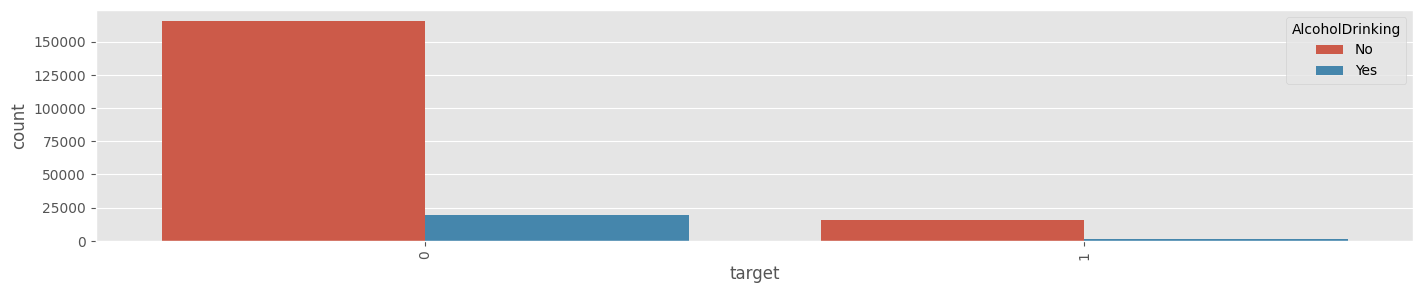

In [ ]:
plt.figure(figsize=[17,3])
plt.xticks(rotation=90)
sns.countplot(data=df, x='target', hue='AlcoholDrinking')

Analisando o grafico e vendo a correlação de pessoas com doenças cardiacas e o consumo de alcool, denota-se um nmero quase irrisorio de pessoas que tomam alcool e tem doenças cardiacas. Tal amostra por ser muito discrepante pode mostrar certo problema na propria amostra, talvez com pessoas tendo vegonha ou medo de admitir consumir alcool ja tendo uma doença cardiaca

In [ ]:
df_drinhing_mean = df[['AlcoholDrinking','target']].groupby(['AlcoholDrinking']).mean()
print(df_drinhing_mean)


                 target
AlcoholDrinking        
No                 0.09
Yes                0.05


Colunas do DataFrame: Index(['AlcoholDrinking', 'HeartDisease'], dtype='object')


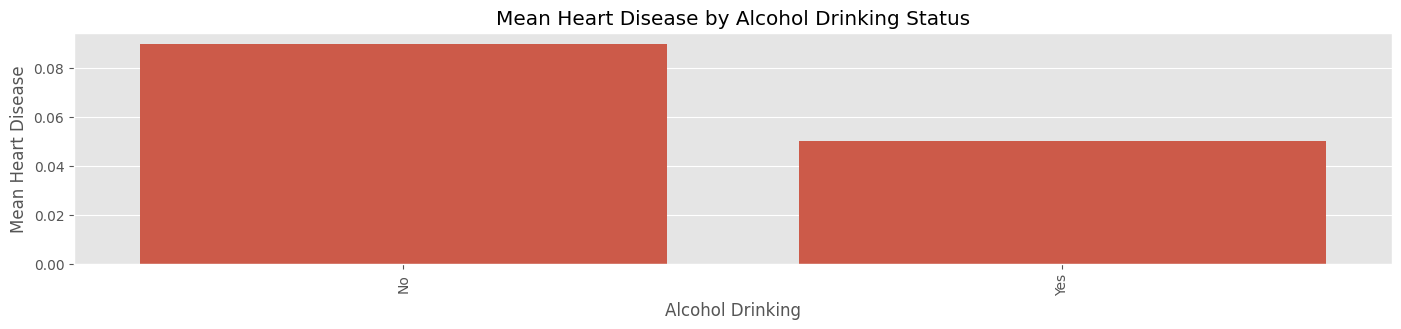

In [ ]:
# Dados originais em um formato pivot
data_drink = {
    'AlcoholDrinking': ['No', 'Yes'],
    'HeartDisease': [0.09, 0.05]
}


df_drinhing_mean = pd.DataFrame(data_drink)

# Verificar as colunas do DataFrame
print("Colunas do DataFrame:", df_drinhing_mean.columns)

# Verifique se as colunas 'HeartDisease' e 'AlcoholDrinking' existem
if 'HeartDisease' in df_drinhing_mean.columns and 'AlcoholDrinking' in df_drinhing_mean.columns:
    plt.figure(figsize=[17, 3])
    plt.xticks(rotation=90)
    sns.barplot(data=df_drinhing_mean, x='AlcoholDrinking', y='HeartDisease')
    plt.xlabel('Alcohol Drinking')
    plt.ylabel('Mean Heart Disease')
    plt.title('Mean Heart Disease by Alcohol Drinking Status')
    plt.show()
else:
    print("As colunas 'HeartDisease' e/ou 'AlcoholDrinking' não existem no DataFrame")

###### E neste grafico, um surpreendente diferença que mostra que pessoas que não consumem alcool tendem a ter quase o dobro a mais de chance de ter doenças cardiacas (de 5 para 9 por cento), com a diferença percentual absoluta tambem sendo de 4 por cento.  Porem, essa analise não pode ser condiderada como verdadeira, devido ao alto numero de falantes, ou seja, sem informação para a coluna.

**4. Definição do Target, Variáveis e Divisão dos Dados**

####**Preparação de Dados**

**Case 1:**


**Limpeza de dados**

Imputação de valores nulos

In [ ]:
# devido ter alterados os valores das variaveis estou carregndo novamente
df =read_dataset()

"heart_disease_data.csv" imported successfully!


Nulos nas variaveis categoricas

In [ ]:
df.select_dtypes(include=['object']).isnull().sum()

,0
HeartDisease,1
Smoking,0
AlcoholDrinking,101504
Stroke,1069
DiffWalking,1
Sex,1
AgeCategory,1
Race,1
Diabetic,1
PhysicalActivity,1


Devido a não saber como preencher os valores nulos, pois se determinarmos a media ou a moda para preencher, poderiamos gerar um erro na analise. Visto que as features pdem ser sensiveis e com isso alterar o comportamento, acarretando erro no modelo. Como solução estarei criando uma categoria a mais que representaram os nulos. Poreriamos excluir as linhas com nulos, mais também não sei prever o quanto intrferiria também as previsões.

Mas o nulo da coluna target será excluída

In [ ]:
df = df.dropna(subset=["HeartDisease"])

In [ ]:
df.select_dtypes(include=['object']).isnull().sum()

,0
HeartDisease,0
Smoking,0
AlcoholDrinking,101503
Stroke,1069
DiffWalking,1
Sex,1
AgeCategory,1
Race,1
Diabetic,1
PhysicalActivity,1


In [ ]:
# Renomear a coluna HeartDisease para target
target_col = 'HeartDisease'  # ou df.columns[0] se for a primeira coluna
df.rename(columns={target_col: 'target'}, inplace=True)

In [ ]:
df.select_dtypes(include=['object']).isnull().sum()

,0
target,0
Smoking,0
AlcoholDrinking,101503
Stroke,1069
DiffWalking,1
Sex,1
AgeCategory,1
Race,1
Diabetic,1
PhysicalActivity,1


In [ ]:
df['AlcoholDrinking'] = df['AlcoholDrinking'].fillna('ZZZ')

In [ ]:
df.select_dtypes(include=['object']).isnull().sum()

,0
target,0
Smoking,0
AlcoholDrinking,0
Stroke,1069
DiffWalking,1
Sex,1
AgeCategory,1
Race,1
Diabetic,1
PhysicalActivity,1


In [ ]:
df['Stroke'] = df['Stroke'].fillna('ZZZ')

In [ ]:
df['SkinCancer'] = df['SkinCancer'].fillna('ZZZ')

In [ ]:
df['Stroke'] = df['Stroke'].fillna('ZZZ')


In [ ]:
df['HeartDisease_FamilyHistory'] = df['HeartDisease_FamilyHistory'].fillna('ZZZ')


In [ ]:
df['DiffWalking'] = df['DiffWalking'].fillna('ZZZ')


In [ ]:
df['Sex'] = df['Sex'].fillna('ZZZ')

In [ ]:
df['AgeCategory'] = df['AgeCategory'].fillna('ZZZ')
df['Race'] = df['Race'].fillna('ZZZ')
df['Diabetic'] = df['Diabetic'].fillna('ZZZ')
df['PhysicalActivity'] = df['PhysicalActivity'].fillna('ZZZ')
df['GenHealth'] = df['GenHealth'].fillna('ZZZ')
df['State'] = df['State'].fillna('ZZZ')


In [ ]:
df.select_dtypes(include=['object']).isnull().sum()


,0
target,0
Smoking,0
AlcoholDrinking,0
Stroke,0
DiffWalking,0
Sex,0
AgeCategory,0
Race,0
Diabetic,0
PhysicalActivity,0


**Nulos nas variaveis não categoricas**

In [ ]:
df.select_dtypes(include=['number']).isnull().sum()

,0
BMI,1
PhysicalHealth,1
MentalHealth,1
SleepTime,1


Para as vareáveis numericas usarei -1

In [ ]:
df['BMI'] = df['BMI'].fillna('ZZZ')
df['MentalHealth'] = df['MentalHealth'].fillna('ZZZ')
df['SleepTime'] = df['SleepTime'].fillna('ZZZ')
df['SleepTime'] = df['SleepTime'].fillna('ZZZ')

In [ ]:
df.head().T

,0,1,2,3,4
target,No,Yes,No,No,No
BMI,57.02,26.43,27.63,22.81,24.33
Smoking,No,Yes,No,No,No
AlcoholDrinking,No,No,No,ZZZ,ZZZ
Stroke,No,No,No,No,No
PhysicalHealth,30.00,30.00,0.00,0.00,0.00
MentalHealth,30.00,15.00,0.00,0.00,0.00
DiffWalking,Yes,Yes,No,No,No
Sex,Female,Female,Female,Female,Male
AgeCategory,35-39,70-74,80 or older,35-39,18-24


***Transformação de dados***

Transformação de variáveis ​​categóricas

a) Transformando o target em um número (não categoriaca)

In [ ]:
df["target"] = df["target"].map({'Yes':1,'No':0})

In [ ]:
print(df["target"].value_counts())

target
0    277994
1     25949
Name: count, dtype: int64


In [ ]:
# Verificar se restaram valores não convertidos
print("Valores únicos em target:", df["target"].unique())

Valores únicos em target: [0 1]


In [ ]:
# Checar se existem NaNs
print("Quantidade de NaNs:", df["target"].isna().sum())

Quantidade de NaNs: 0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,"303,943.00",0.09,0.28,0.00,0.00,0.00,0.00,1.00
PhysicalHealth,"303,942.00",3.36,7.94,0.00,0.00,0.00,2.00,30.00


As variaveis Smoking, AlcoholDrinking, Stroke, DiffWalking, Sex, AgeCategory, Race, PhysicalActivity, Diabetic, GenHealth, KidneyDisease, SkinCancer, HeartDisease_FamilyHistory e State são variaveis ideais para one-hot-encoding.

Análise de State

In [ ]:
df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
BMI,"303,943.00","3,571.00",26.63,"3,587.00"
Smoking,303943,3,No,178669
AlcoholDrinking,303943,3,No,181686
Stroke,303943,3,No,291495
MentalHealth,"303,943.00",32.00,0.00,"194,915.00"
DiffWalking,303943,3,No,261966
Sex,303943,3,Female,159041
AgeCategory,303943,15,65-69,32329
Race,303943,7,White,234438
Diabetic,303943,5,No,256533


In [ ]:
df.pivot_table(index='State', values='target', aggfunc=[len, sum, np.mean]).sort_values(by=[('mean','target')], ascending = False)

/tmp/ipython-input-4168737511.py:1: FutureWarning:

The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.

/tmp/ipython-input-4168737511.py:1: FutureWarning:

The provided callable <function mean at 0x7d16c9170900> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



,len,sum,mean
,target,target,target
State,,,
MA,5978,554,0.09
TN,6035,557,0.09
CO,5928,536,0.09
WY,5837,524,0.09
CA,6060,544,0.09
ME,6062,541,0.09
OK,6001,535,0.09
WA,6009,535,0.09


c) Frequency encoding para State

In [ ]:
df_state_num= ""

In [ ]:
df_state_num = pd.DataFrame(df['State'].value_counts(dropna = False))
df_state_num.columns = ['State_NUM_COUNT']
df_state_num['State'] = df_state_num.index

In [ ]:
df_state_num.head()

,State_NUM_COUNT,State
State,,
OH,6109,OH
MS,6096,MS
VA,6080,VA
TX,6063,TX
ME,6062,ME


df_state_num contém o número de estados. Vamos mesclá-lo com nosso dataframe original e descartar a variável State (não a usaremos mais)

In [ ]:
print(df.columns[df.columns.duplicated()])
print(df_state_num.columns[df_state_num.columns.duplicated()])

Index([], dtype='object')
Index([], dtype='object')


In [ ]:
# Criar dataframe com contagem dos estados
df_state_num = df['State'].value_counts(dropna=False).reset_index()

In [ ]:
# Renomear as colunas
df_state_num.columns = ['State', 'State_NUM_COUNT']

In [ ]:
# Fazer o merge sem ambiguidade
df = df.merge(df_state_num, on='State', how='left')

In [ ]:
df.columns

Index(['target', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'HeartDisease_FamilyHistory',
       'State', 'State_NUM_COUNT'],
      dtype='object')

In [ ]:
df.drop('State', axis = 1, inplace = True)

In [ ]:
# Obter valores distintos da coluna 'State'
valores_distintos = df['State_NUM_COUNT'].unique()
print (valores_distintos)

[6063 6008 5981 6045 5923 5911 6060 5888 6018 5984 6042 5845 5944 5917
 6001 5969 5978 6052 6029 6080 5861 5921 5866 6096 5961 5892 5950 5859
 5896 5928 5924 5864 5816 5983 5965 6009 5793 5942 6039 6035 5906 6109
 5889 6062 5837    1]


#### Virando  a target em um número (não categórico)

In [ ]:
df.select_dtypes(include=['number']).describe().T

,count,mean,std,min,25%,50%,75%,max
target,"303,943.00",0.09,0.28,0.00,0.00,0.00,0.00,1.00
PhysicalHealth,"303,942.00",3.36,7.94,0.00,0.00,0.00,2.00,30.00
State_NUM_COUNT,"303,943.00","5,960.55",77.22,1.00,"5,906.00","5,965.00","6,018.00","6,109.00"


In [ ]:
df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
BMI,"303,943.00","3,571.00",26.63,"3,587.00"
Smoking,303943,3,No,178669
AlcoholDrinking,303943,3,No,181686
Stroke,303943,3,No,291495
MentalHealth,"303,943.00",32.00,0.00,"194,915.00"
DiffWalking,303943,3,No,261966
Sex,303943,3,Female,159041
AgeCategory,303943,15,65-69,32329
Race,303943,7,White,234438
Diabetic,303943,5,No,256533


In [ ]:
df.columns

Index(['target', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'HeartDisease_FamilyHistory',
       'State_NUM_COUNT'],
      dtype='object')

**One-hot-encoding**

#### a) One-hot-encoding para AgeCategory

Referência da API Funções gerais (pandas.get_dummies converter variáveis)
​​categóricas em variáveis ​​fictícias/indicadoras.

In [ ]:
_dummy_dataset = pd.get_dummies(df['AgeCategory'], prefix='AgeCategory', dtype=int)

In [ ]:
df = pd.concat([df,_dummy_dataset],axis=1)

In [ ]:
df.head(2)

,target,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ
0,0,57.02,No,No,No,30.00,30.00,Yes,Female,35-39,White,No,No,Poor,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,26.43,Yes,No,No,30.00,15.00,Yes,Female,70-74,White,Yes,No,Poor,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
df.drop(['AgeCategory'],axis=1, inplace=True)

In [ ]:
df.head(2)

,target,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ
0,0,57.02,No,No,No,30.00,30.00,Yes,Female,White,No,No,Poor,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,26.43,Yes,No,No,30.00,15.00,Yes,Female,White,Yes,No,Poor,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


b) One-hot-encoding para GenHealth

In [ ]:
_dummy_dataset = pd.get_dummies(df['GenHealth'], prefix='GenHealth', dtype=int)

In [ ]:
df = pd.concat([df,_dummy_dataset],axis=1)

In [ ]:
df.head(2)

,target,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ
0,0,57.02,No,No,No,30.00,30.00,Yes,Female,White,No,No,Poor,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,26.43,Yes,No,No,30.00,15.00,Yes,Female,White,Yes,No,Poor,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
df.drop(['GenHealth'],axis=1, inplace=True)

In [ ]:
df.head(2)

,target,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Race,Diabetic,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ
0,0,57.02,No,No,No,30.00,30.00,Yes,Female,White,No,No,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,26.43,Yes,No,No,30.00,15.00,Yes,Female,White,Yes,No,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


c) One-hot-encoding para Diabetic

In [ ]:
df['Diabetic'] = df['Diabetic'].replace({'No':'No',
                                         'No, borderline diabetes':'No',
                                         'Yes':'Yes',
                                         'Yes (during pregnancy)':'Yes'})

In [ ]:
df['Diabetic'].head()

,Diabetic
0,No
1,Yes
2,No
3,No
4,No


In [ ]:
_dummy_dataset = pd.get_dummies(df['Diabetic'], prefix='Diabetic', dtype=int)

In [ ]:
df = pd.concat([df,_dummy_dataset],axis=1)

In [ ]:
df.head(2)

,target,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Race,Diabetic,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ
0,0,57.02,No,No,No,30.00,30.00,Yes,Female,White,No,No,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,1,26.43,Yes,No,No,30.00,15.00,Yes,Female,White,Yes,No,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
df.drop(['Diabetic'],axis=1, inplace=True)

In [ ]:
df.head(2)

,target,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Race,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ
0,0,57.02,No,No,No,30.00,30.00,Yes,Female,White,No,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,1,26.43,Yes,No,No,30.00,15.00,Yes,Female,White,No,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


d) One-hot-encoding para Smoking

In [ ]:
print(df['Smoking'].unique())

['No' 'Yes' 'LA']


Irei deletar o dado LA devido a erro de digitação

In [ ]:
df = df[df['Smoking'] != 'LA']

In [ ]:
print(df['Smoking'].unique())

['No' 'Yes']


In [ ]:
_dummy_dataset = pd.get_dummies(df['Smoking'], prefix='Smoking', dtype=int)

In [ ]:
print(_dummy_dataset)

        Smoking_No  Smoking_Yes
0                1            0
1                0            1
2                1            0
3                1            0
4                1            0
...            ...          ...
303938           1            0
303939           0            1
303940           1            0
303941           1            0
303942           1            0

[303942 rows x 2 columns]


In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)

In [ ]:
df.columns

Index(['target', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'Race',
       'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'HeartDisease_FamilyHistory', 'State_NUM_COUNT',
       'AgeCategory_0', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'AgeCategory_ZZZ',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good', 'GenHealth_ZZZ', 'Diabetic_No',
       'Diabetic_Yes', 'Diabetic_ZZZ', 'Smoking_No', 'Smoking_Yes'],
      dtype='object')

In [ ]:
df.head(2)

,target,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Race,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes
0,0,57.02,No,No,No,30.00,30.00,Yes,Female,White,No,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
1,1,26.43,Yes,No,No,30.00,15.00,Yes,Female,White,No,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1


e) One-hot-encoding para AlcoholDrinking

In [ ]:
print(df['AlcoholDrinking'].unique())

['No' 'ZZZ' 'Yes']


In [ ]:
_dummy_dataset = pd.get_dummies(df['AlcoholDrinking'], prefix='AlcoholDrinking', dtype=int)

In [ ]:
print(_dummy_dataset)

        AlcoholDrinking_No  AlcoholDrinking_Yes  AlcoholDrinking_ZZZ
0                        1                    0                    0
1                        1                    0                    0
2                        1                    0                    0
3                        0                    0                    1
4                        0                    0                    1
...                    ...                  ...                  ...
303938                   0                    0                    1
303939                   0                    0                    1
303940                   0                    0                    1
303941                   0                    1                    0
303942                   1                    0                    0

[303942 rows x 3 columns]


In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)

In [ ]:
df.head(2)

,target,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Race,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ
0,0,57.02,No,No,No,30.00,30.00,Yes,Female,White,No,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
1,1,26.43,Yes,No,No,30.00,15.00,Yes,Female,White,No,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0


In [ ]:
df.drop(['AlcoholDrinking'],axis=1, inplace=True)
df.columns

Index(['target', 'BMI', 'Smoking', 'Stroke', 'PhysicalHealth', 'MentalHealth',
       'DiffWalking', 'Sex', 'Race', 'PhysicalActivity', 'SleepTime', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'HeartDisease_FamilyHistory',
       'State_NUM_COUNT', 'AgeCategory_0', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older',
       'AgeCategory_ZZZ', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good',
       'GenHealth_ZZZ', 'Diabetic_No', 'Diabetic_Yes', 'Diabetic_ZZZ',
       'Smoking_No', 'Smoking_Yes', 'AlcoholDrinking_No',
       'AlcoholDrinking_Yes', 'AlcoholDrinking_ZZZ'],
      dtype='object')

f) One-hot-encoding para Stroke

In [ ]:
print(df['Stroke'].unique())

['No' 'Yes' 'ZZZ']


In [ ]:
_dummy_dataset = pd.get_dummies(df['Stroke'], prefix='Stroke', dtype=int)

In [ ]:
_dummy_dataset.columns

Index(['Stroke_No', 'Stroke_Yes', 'Stroke_ZZZ'], dtype='object')

In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)

In [ ]:
df.head(2)

,target,BMI,Smoking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Race,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ
0,0,57.02,No,No,30.00,30.00,Yes,Female,White,No,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0
1,1,26.43,Yes,No,30.00,15.00,Yes,Female,White,No,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0


In [ ]:
df.drop(['Stroke'],axis=1, inplace=True)
df.columns

Index(['target', 'BMI', 'Smoking', 'PhysicalHealth', 'MentalHealth',
       'DiffWalking', 'Sex', 'Race', 'PhysicalActivity', 'SleepTime', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'HeartDisease_FamilyHistory',
       'State_NUM_COUNT', 'AgeCategory_0', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older',
       'AgeCategory_ZZZ', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good',
       'GenHealth_ZZZ', 'Diabetic_No', 'Diabetic_Yes', 'Diabetic_ZZZ',
       'Smoking_No', 'Smoking_Yes', 'AlcoholDrinking_No',
       'AlcoholDrinking_Yes', 'AlcoholDrinking_ZZZ', 'Stroke_No', 'Stroke_Yes',
       'Stroke_ZZZ'],
      dtype='object')

g) One-hot-encoding para DiffWalking

In [ ]:
print(df['DiffWalking'].unique())

['Yes' 'No']


In [ ]:
_dummy_dataset = pd.get_dummies(df['DiffWalking'], prefix='DiffWalking', dtype=int)
print(_dummy_dataset)

        DiffWalking_No  DiffWalking_Yes
0                    0                1
1                    0                1
2                    1                0
3                    1                0
4                    1                0
...                ...              ...
303938               1                0
303939               1                0
303940               1                0
303941               1                0
303942               0                1

[303942 rows x 2 columns]


In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)
df.head(2)

,target,BMI,Smoking,PhysicalHealth,MentalHealth,DiffWalking,Sex,Race,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ,DiffWalking_No,DiffWalking_Yes
0,0,57.02,No,30.00,30.00,Yes,Female,White,No,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
1,1,26.43,Yes,30.00,15.00,Yes,Female,White,No,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1


In [ ]:
df.drop(['DiffWalking'],axis=1, inplace=True)
df.columns

Index(['target', 'BMI', 'Smoking', 'PhysicalHealth', 'MentalHealth', 'Sex',
       'Race', 'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'HeartDisease_FamilyHistory', 'State_NUM_COUNT',
       'AgeCategory_0', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'AgeCategory_ZZZ',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good', 'GenHealth_ZZZ', 'Diabetic_No',
       'Diabetic_Yes', 'Diabetic_ZZZ', 'Smoking_No', 'Smoking_Yes',
       'AlcoholDrinking_No', 'AlcoholDrinking_Yes', 'AlcoholDrinking_ZZZ',
       'Stroke_No', 'Stroke_Yes', 'Stroke_ZZZ', 'DiffWalking_No',
       'DiffWalking_Yes'],
      dtype='object')

Sex

In [ ]:
print(df['Sex'].unique())

['Female' 'Male']


In [ ]:
_dummy_dataset = pd.get_dummies(df['Sex'], prefix='Sex', dtype=int)

In [ ]:
_dummy_dataset.columns

Index(['Sex_Female', 'Sex_Male'], dtype='object')

In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)

In [ ]:
df.head(2)

,target,BMI,Smoking,PhysicalHealth,MentalHealth,Sex,Race,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male
0,0,57.02,No,30.00,30.00,Female,White,No,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0
1,1,26.43,Yes,30.00,15.00,Female,White,No,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,1,0


In [ ]:
df.drop(['Sex'],axis=1, inplace=True)
df.columns

Index(['target', 'BMI', 'Smoking', 'PhysicalHealth', 'MentalHealth', 'Race',
       'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'HeartDisease_FamilyHistory', 'State_NUM_COUNT',
       'AgeCategory_0', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'AgeCategory_ZZZ',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good', 'GenHealth_ZZZ', 'Diabetic_No',
       'Diabetic_Yes', 'Diabetic_ZZZ', 'Smoking_No', 'Smoking_Yes',
       'AlcoholDrinking_No', 'AlcoholDrinking_Yes', 'AlcoholDrinking_ZZZ',
       'Stroke_No', 'Stroke_Yes', 'Stroke_ZZZ', 'DiffWalking_No',
       'DiffWalking_Yes', 'Sex_Female', 'Sex_Male'],
      dtype='object')

Race

In [ ]:
print(df['Race'].unique())

['White' 'Hispanic' 'American Indian/Alaskan Native' 'Other' 'Asian'
 'Black']


In [ ]:
_dummy_dataset = pd.get_dummies(df['Race'], prefix='Race', dtype=int)
_dummy_dataset.columns

Index(['Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White'],
      dtype='object')

In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)
df.head(2)

,target,BMI,Smoking,PhysicalHealth,MentalHealth,Race,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,0,57.02,No,30.00,30.00,White,No,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1
1,1,26.43,Yes,30.00,15.00,White,No,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1


In [ ]:
df.drop(['Race'],axis=1, inplace=True)
df.columns

Index(['target', 'BMI', 'Smoking', 'PhysicalHealth', 'MentalHealth',
       'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'HeartDisease_FamilyHistory', 'State_NUM_COUNT',
       'AgeCategory_0', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'AgeCategory_ZZZ',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good', 'GenHealth_ZZZ', 'Diabetic_No',
       'Diabetic_Yes', 'Diabetic_ZZZ', 'Smoking_No', 'Smoking_Yes',
       'AlcoholDrinking_No', 'AlcoholDrinking_Yes', 'AlcoholDrinking_ZZZ',
       'Stroke_No', 'Stroke_Yes', 'Stroke_ZZZ', 'DiffWalking_No',
       'DiffWalking_Yes', 'Sex_Female', 'Sex_Male',
       'Race_American Indian/Alaskan 

PhysicalActivity

In [ ]:
_dummy_dataset = pd.get_dummies(df['PhysicalActivity'], prefix='PhysicalActivity', dtype=int)
_dummy_dataset.columns

Index(['PhysicalActivity_No', 'PhysicalActivity_Yes'], dtype='object')

In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)
df.head(2)

,target,BMI,Smoking,PhysicalHealth,MentalHealth,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,PhysicalActivity_No,PhysicalActivity_Yes
0,0,57.02,No,30.00,30.00,No,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0
1,1,26.43,Yes,30.00,15.00,No,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0


In [ ]:
df.drop(['PhysicalActivity'],axis=1, inplace=True)
df.columns

Index(['target', 'BMI', 'Smoking', 'PhysicalHealth', 'MentalHealth',
       'SleepTime', 'Asthma', 'KidneyDisease', 'SkinCancer',
       'HeartDisease_FamilyHistory', 'State_NUM_COUNT', 'AgeCategory_0',
       'AgeCategory_18-24', 'AgeCategory_25-29', 'AgeCategory_30-34',
       'AgeCategory_35-39', 'AgeCategory_40-44', 'AgeCategory_45-49',
       'AgeCategory_50-54', 'AgeCategory_55-59', 'AgeCategory_60-64',
       'AgeCategory_65-69', 'AgeCategory_70-74', 'AgeCategory_75-79',
       'AgeCategory_80 or older', 'AgeCategory_ZZZ', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good', 'GenHealth_ZZZ', 'Diabetic_No', 'Diabetic_Yes',
       'Diabetic_ZZZ', 'Smoking_No', 'Smoking_Yes', 'AlcoholDrinking_No',
       'AlcoholDrinking_Yes', 'AlcoholDrinking_ZZZ', 'Stroke_No', 'Stroke_Yes',
       'Stroke_ZZZ', 'DiffWalking_No', 'DiffWalking_Yes', 'Sex_Female',
       'Sex_Male', 'Race_American Indian/Alaskan Native', 'Race_Asian',
    

In [ ]:
df.head(2)

,target,BMI,Smoking,PhysicalHealth,MentalHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,PhysicalActivity_No,PhysicalActivity_Yes
0,0,57.02,No,30.00,30.00,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0
1,1,26.43,Yes,30.00,15.00,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0


Asthma

In [ ]:
print(df['Asthma'].unique())

['No' 'Yes']


In [ ]:
_dummy_dataset = pd.get_dummies(df['Asthma'], prefix='Asthma', dtype=int)
_dummy_dataset.columns

Index(['Asthma_No', 'Asthma_Yes'], dtype='object')

In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)
df.head(2)

,target,BMI,Smoking,PhysicalHealth,MentalHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,PhysicalActivity_No,PhysicalActivity_Yes,Asthma_No,Asthma_Yes
0,0,57.02,No,30.00,30.00,9.00,No,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0
1,1,26.43,Yes,30.00,15.00,6.00,No,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0


In [ ]:
df.drop(['Asthma'],axis=1, inplace=True)
df.columns

Index(['target', 'BMI', 'Smoking', 'PhysicalHealth', 'MentalHealth',
       'SleepTime', 'KidneyDisease', 'SkinCancer',
       'HeartDisease_FamilyHistory', 'State_NUM_COUNT', 'AgeCategory_0',
       'AgeCategory_18-24', 'AgeCategory_25-29', 'AgeCategory_30-34',
       'AgeCategory_35-39', 'AgeCategory_40-44', 'AgeCategory_45-49',
       'AgeCategory_50-54', 'AgeCategory_55-59', 'AgeCategory_60-64',
       'AgeCategory_65-69', 'AgeCategory_70-74', 'AgeCategory_75-79',
       'AgeCategory_80 or older', 'AgeCategory_ZZZ', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good', 'GenHealth_ZZZ', 'Diabetic_No', 'Diabetic_Yes',
       'Diabetic_ZZZ', 'Smoking_No', 'Smoking_Yes', 'AlcoholDrinking_No',
       'AlcoholDrinking_Yes', 'AlcoholDrinking_ZZZ', 'Stroke_No', 'Stroke_Yes',
       'Stroke_ZZZ', 'DiffWalking_No', 'DiffWalking_Yes', 'Sex_Female',
       'Sex_Male', 'Race_American Indian/Alaskan Native', 'Race_Asian',
       'Race_B

KidneyDisease

In [ ]:
print(df['KidneyDisease'].unique())

['No' 'Yes']


In [ ]:
_dummy_dataset = pd.get_dummies(df['KidneyDisease'], prefix='KidneyDisease', dtype=int)
_dummy_dataset.columns

Index(['KidneyDisease_No', 'KidneyDisease_Yes'], dtype='object')

In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)
df.head(2)

,target,BMI,Smoking,PhysicalHealth,MentalHealth,SleepTime,KidneyDisease,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,PhysicalActivity_No,PhysicalActivity_Yes,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes
0,0,57.02,No,30.00,30.00,9.00,No,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,1,0
1,1,26.43,Yes,30.00,15.00,6.00,Yes,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1


In [ ]:
df.drop(['KidneyDisease'],axis=1, inplace=True)
df.columns

Index(['target', 'BMI', 'Smoking', 'PhysicalHealth', 'MentalHealth',
       'SleepTime', 'SkinCancer', 'HeartDisease_FamilyHistory',
       'State_NUM_COUNT', 'AgeCategory_0', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older',
       'AgeCategory_ZZZ', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good',
       'GenHealth_ZZZ', 'Diabetic_No', 'Diabetic_Yes', 'Diabetic_ZZZ',
       'Smoking_No', 'Smoking_Yes', 'AlcoholDrinking_No',
       'AlcoholDrinking_Yes', 'AlcoholDrinking_ZZZ', 'Stroke_No', 'Stroke_Yes',
       'Stroke_ZZZ', 'DiffWalking_No', 'DiffWalking_Yes', 'Sex_Female',
       'Sex_Male', 'Race_American Indian/Alaskan Native', 'Race_Asian',
       'Race_Black', 'Race_Hisp

SkinCancer

In [ ]:
print(df['SkinCancer'].unique())

['No' 'Yes' 'ZZZ']


In [ ]:
_dummy_dataset = pd.get_dummies(df['SkinCancer'], prefix='KidneyDisease', dtype=int)
_dummy_dataset.columns

Index(['KidneyDisease_No', 'KidneyDisease_Yes', 'KidneyDisease_ZZZ'], dtype='object')

In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)
df.head(2)

,target,BMI,Smoking,PhysicalHealth,MentalHealth,SleepTime,SkinCancer,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,PhysicalActivity_No,PhysicalActivity_Yes,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,KidneyDisease_No,KidneyDisease_Yes,KidneyDisease_ZZZ
0,0,57.02,No,30.00,30.00,9.00,No,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0
1,1,26.43,Yes,30.00,15.00,6.00,No,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0


In [ ]:
df.drop(['SkinCancer'],axis=1, inplace=True)
df.columns

Index(['target', 'BMI', 'Smoking', 'PhysicalHealth', 'MentalHealth',
       'SleepTime', 'HeartDisease_FamilyHistory', 'State_NUM_COUNT',
       'AgeCategory_0', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'AgeCategory_ZZZ',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good', 'GenHealth_ZZZ', 'Diabetic_No',
       'Diabetic_Yes', 'Diabetic_ZZZ', 'Smoking_No', 'Smoking_Yes',
       'AlcoholDrinking_No', 'AlcoholDrinking_Yes', 'AlcoholDrinking_ZZZ',
       'Stroke_No', 'Stroke_Yes', 'Stroke_ZZZ', 'DiffWalking_No',
       'DiffWalking_Yes', 'Sex_Female', 'Sex_Male',
       'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_O

HeartDisease_FamilyHistory

In [ ]:
print(df['HeartDisease_FamilyHistory'].unique())

['ZZZ' 'No' 'Yes']


In [ ]:
_dummy_dataset = pd.get_dummies(df['HeartDisease_FamilyHistory'], prefix='HeartDisease_FamilyHistory', dtype=int)
_dummy_dataset.columns

Index(['HeartDisease_FamilyHistory_No', 'HeartDisease_FamilyHistory_Yes',
       'HeartDisease_FamilyHistory_ZZZ'],
      dtype='object')

In [ ]:
df = pd.concat([df, _dummy_dataset], axis=1)
df.head(2)

,target,BMI,Smoking,PhysicalHealth,MentalHealth,SleepTime,HeartDisease_FamilyHistory,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,PhysicalActivity_No,PhysicalActivity_Yes,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,KidneyDisease_No,KidneyDisease_Yes,KidneyDisease_ZZZ,HeartDisease_FamilyHistory_No,HeartDisease_FamilyHistory_Yes,HeartDisease_FamilyHistory_ZZZ
0,0,57.02,No,30.00,30.00,9.00,ZZZ,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,1
1,1,26.43,Yes,30.00,15.00,6.00,ZZZ,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1


In [ ]:
df.drop(['HeartDisease_FamilyHistory'],axis=1, inplace=True)
df.columns

Index(['target', 'BMI', 'Smoking', 'PhysicalHealth', 'MentalHealth',
       'SleepTime', 'State_NUM_COUNT', 'AgeCategory_0', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older',
       'AgeCategory_ZZZ', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good',
       'GenHealth_ZZZ', 'Diabetic_No', 'Diabetic_Yes', 'Diabetic_ZZZ',
       'Smoking_No', 'Smoking_Yes', 'AlcoholDrinking_No',
       'AlcoholDrinking_Yes', 'AlcoholDrinking_ZZZ', 'Stroke_No', 'Stroke_Yes',
       'Stroke_ZZZ', 'DiffWalking_No', 'DiffWalking_Yes', 'Sex_Female',
       'Sex_Male', 'Race_American Indian/Alaskan Native', 'Race_Asian',
       'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'Physical

In [ ]:
df.head(2)

,target,BMI,Smoking,PhysicalHealth,MentalHealth,SleepTime,State_NUM_COUNT,AgeCategory_0,AgeCategory_18-24,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,AgeCategory_ZZZ,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,GenHealth_ZZZ,Diabetic_No,Diabetic_Yes,Diabetic_ZZZ,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,AlcoholDrinking_ZZZ,Stroke_No,Stroke_Yes,Stroke_ZZZ,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,PhysicalActivity_No,PhysicalActivity_Yes,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,KidneyDisease_No,KidneyDisease_Yes,KidneyDisease_ZZZ,HeartDisease_FamilyHistory_No,HeartDisease_FamilyHistory_Yes,HeartDisease_FamilyHistory_ZZZ
0,0,57.02,No,30.00,30.00,9.00,6063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,1
1,1,26.43,Yes,30.00,15.00,6.00,6008,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0,1


***Divisão dos dados***

***Baseline e modelos candidatos***

In [ ]:
print("Total de linhas do dataframe : ",df.shape[0])

Total de linhas do dataframe :  303942


In [ ]:
import time
from sklearn.model_selection import train_test_split

# ========================
# Configurações principais
# ========================
SEED = 42
PROBLEM_TYPE = "classificacao"   # você já definiu que é classificação

# ========================
# Definição de target/features
# ========================
if PROBLEM_TYPE == "classificacao":
    target = "target"   # <-- já existe no seu dataset
    features = [c for c in df.columns if c != target]

elif PROBLEM_TYPE == "regressao":
    target = "target"
    features = [c for c in df.columns if c != target]

elif PROBLEM_TYPE == "clusterizacao":
    target = None
    features = [c for c in df.columns if c != "target"]

else:
    raise ValueError("❌ PROBLEM_TYPE inválido.")

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))

# ========================
# Split dos dados
# ========================

if PROBLEM_TYPE in ["classificacao", "regressao"]:
    X = df[features].copy()
    y = df[target].copy()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED,
        stratify=y if PROBLEM_TYPE == "classificacao" else None
    )
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)

elif PROBLEM_TYPE == "clusterizacao":
    X = df[features].copy()
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=SEED)
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)


PROBLEM_TYPE: classificacao
Target: target
N features: 60
Treino: (243153, 64) | Teste: (60789, 64)


In [ ]:
from sklearn.metrics import(accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, log_loss, mean_squared_error, mean_absolute_error, r2_score
)
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)  # Suprime warnings

# ========================
# Funções de avaliação
# ========================
def evaluate_classification(y_true, y_pred, proba=None):
    results = {
        "accuracy": round(accuracy_score(y_true, y_pred), 3),
        "f1": round(f1_score(y_true, y_pred, average="weighted"), 3),
        "precision": round(precision_score(y_true, y_pred, average="weighted", zero_division=0), 3),
        "recall": round(recall_score(y_true, y_pred, average="weighted"), 3)
    }
    if proba is not None:
        try:
            results["roc_auc"] = round(
                roc_auc_score(y_true, proba[:,1]), 3
            ) if proba.shape[1] == 2 else None
            results["log_loss"] = round(log_loss(y_true, proba), 3)
        except Exception:
            results["roc_auc"] = None
            results["log_loss"] = None
    return results

def evaluate_regression(y_true, y_pred):
    results = {
        "rmse": round(np.sqrt(mean_squared_error(y_true, y_pred)), 3),
        "mae": round(mean_absolute_error(y_true, y_pred), 3),
        "r2": round(r2_score(y_true, y_pred), 3)
    }
    return results

# ========================
# Criação do baseline
# ========================
if PROBLEM_TYPE == "classificacao":
    from sklearn.dummy import DummyClassifier
    baseline = DummyClassifier(strategy="most_frequent", random_state=SEED)
elif PROBLEM_TYPE == "regressao":
    from sklearn.dummy import DummyRegressor
    baseline = DummyRegressor(strategy="mean")
else:
    baseline = None

# ========================
# Treino e avaliação do baseline
# ========================
results = {}

if PROBLEM_TYPE in ["classificacao", "regressao"]:
    t0 = time.time()
    baseline.fit(X_train, y_train)
    t1 = time.time()

    if PROBLEM_TYPE == "classificacao":
        y_pred = baseline.predict(X_test)
        proba = baseline.predict_proba(X_test) if hasattr(baseline, "predict_proba") else None
        results["baseline"] = evaluate_classification(y_test, y_pred, proba)
    else:
        y_pred = baseline.predict(X_test)
        results["baseline"] = evaluate_regression(y_test, y_pred)

    results["baseline"]["train_time_s"] = round(t1 - t0, 3)

# ========================
# Resultados finais + ranking
# ========================
df_results = pd.DataFrame(results).T

if PROBLEM_TYPE == "classificacao":
    df_ranked = df_results.sort_values(by="accuracy", ascending=False)
elif PROBLEM_TYPE == "regressao":
    df_ranked = df_results.sort_values(by="rmse", ascending=True)
else:
    df_ranked = df_results.copy()

print("\n📊 Resultados ordenados:")
print(df_ranked)



📊 Resultados ordenados:
          accuracy   f1  precision  recall  roc_auc  log_loss  train_time_s
baseline      0.92 0.87       0.84    0.92     0.50      3.08          0.02


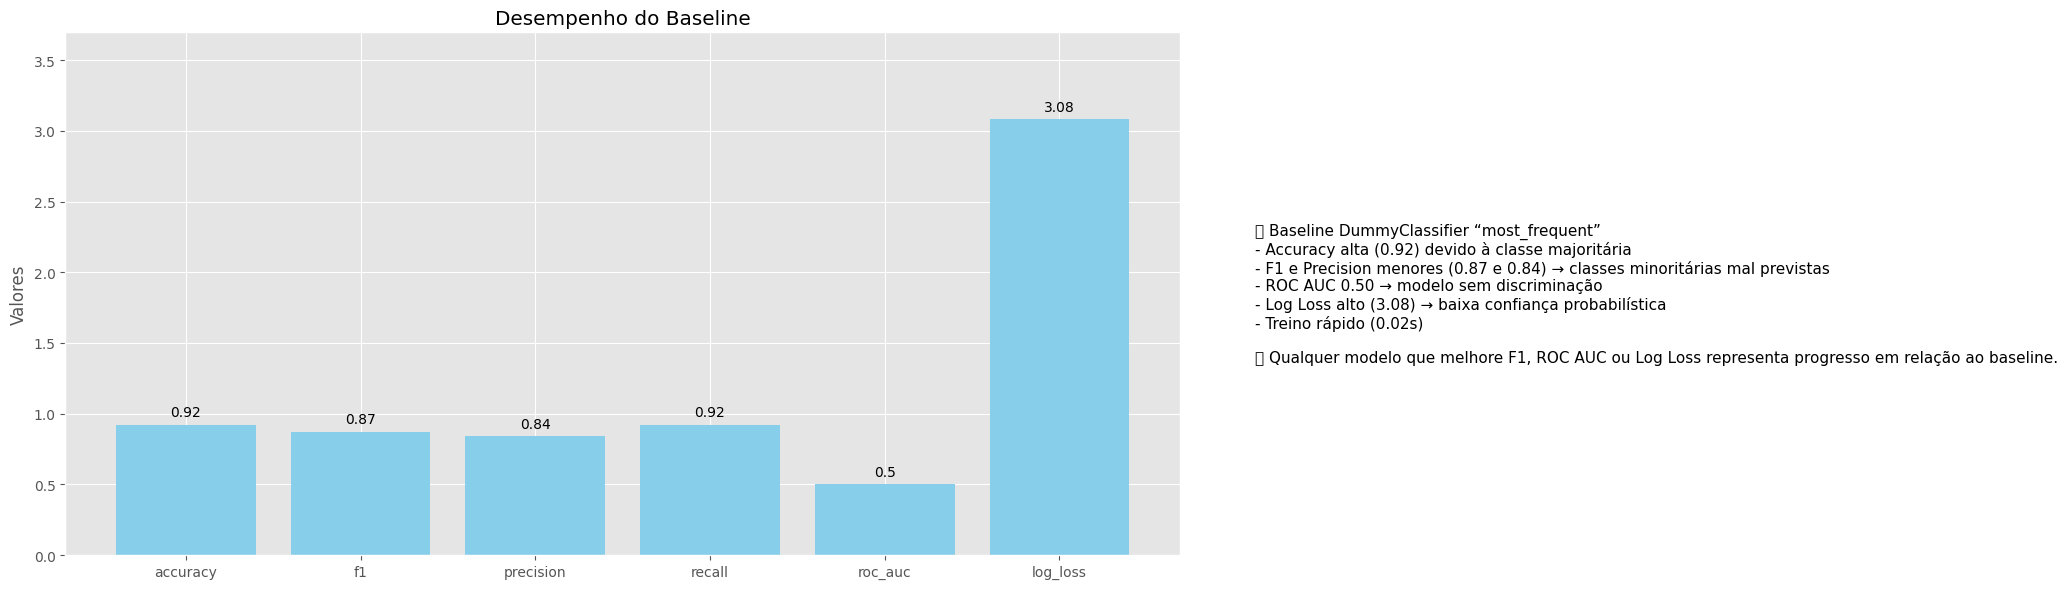

In [ ]:
import matplotlib.pyplot as plt

# ========================
# Dados do baseline
# ========================
metrics = ["accuracy", "f1", "precision", "recall", "roc_auc", "log_loss"]
values = [0.92, 0.87, 0.84, 0.92, 0.50, 3.08]

# ========================
# Figura combinada
# ========================
fig, ax = plt.subplots(figsize=(12,6))

# Gráfico de barras
ax.bar(metrics, values, color="skyblue")
ax.set_ylim(0, max(values)*1.2)
ax.set_ylabel("Valores")
ax.set_title("Desempenho do Baseline")

# Adiciona valores acima das barras
for i, v in enumerate(values):
    ax.text(i, v + 0.02*max(values), str(v), ha='center', fontsize=10)

# Texto resumido ao lado
conclusion_text = (
    "✅ Baseline DummyClassifier “most_frequent”\n"
    "- Accuracy alta (0.92) devido à classe majoritária\n"
    "- F1 e Precision menores (0.87 e 0.84) → classes minoritárias mal previstas\n"
    "- ROC AUC 0.50 → modelo sem discriminação\n"
    "- Log Loss alto (3.08) → baixa confiança probabilística\n"
    "- Treino rápido (0.02s)\n\n"
    "💡 Qualquer modelo que melhore F1, ROC AUC ou Log Loss representa progresso em relação ao baseline."
)

# Adiciona o texto na figura
plt.gcf().text(1.05, 0.5, conclusion_text, fontsize=11, va='center')

plt.tight_layout()
plt.show()





Métrica	Valor	Interpretação

Accuracy	0.92	O modelo acerta 92% das previsões, mas isso é provavelmente porque ele sempre prevê a classe mais frequente (DummyClassifier "most_frequent").

F1 Score	0.87	Considera equilíbrio entre precisão e recall. Um pouco menor que a accuracy, indicando que o modelo não trata bem as classes minoritárias.

Precision	0.84	Quando prevê uma classe, está correta 84% das vezes — mas classes minoritárias têm precision 0, por isso a média ponderada cai.

Recall	0.92	O modelo consegue “recuperar” 92% das instâncias da classe majoritária, mas classes minoritárias são praticamente ignoradas.

ROC AUC	0.50	Valor neutro, equivalente a um modelo aleatório. Esperado para um DummyClassifier.

Log Loss	3.08	Relativamente alto, mostrando baixa confiança probabilística do modelo.

Train Time	0.02s	Treino instantâneo, sem custo computacional.

Conclusão do Baseline

O modelo baseline (DummyClassifier “most_frequent”) apresenta as seguintes características:

Accuracy de 92%, refletindo apenas a previsão da classe mais frequente.

F1 e Precision menores (0.87 e 0.84), mostrando que o modelo não trata bem as classes minoritárias.

ROC AUC de 0.50, equivalente a um modelo aleatório, indicando que não há discriminação entre classes.

Log Loss alto (3.08), reforçando baixa confiança nas probabilidades previstas.

Treino extremamente rápido (0.02s), sem custo computacional significativo.

Conclusão: o baseline serve como referência mínima. Qualquer modelo treinado que apresente melhor F1, ROC AUC ou log loss já representa melhoria significativa em relação ao baseline. É importante focar em modelos que consigam capturar melhor as classes minoritárias, aumentando a capacidade preditiva real do sistema.

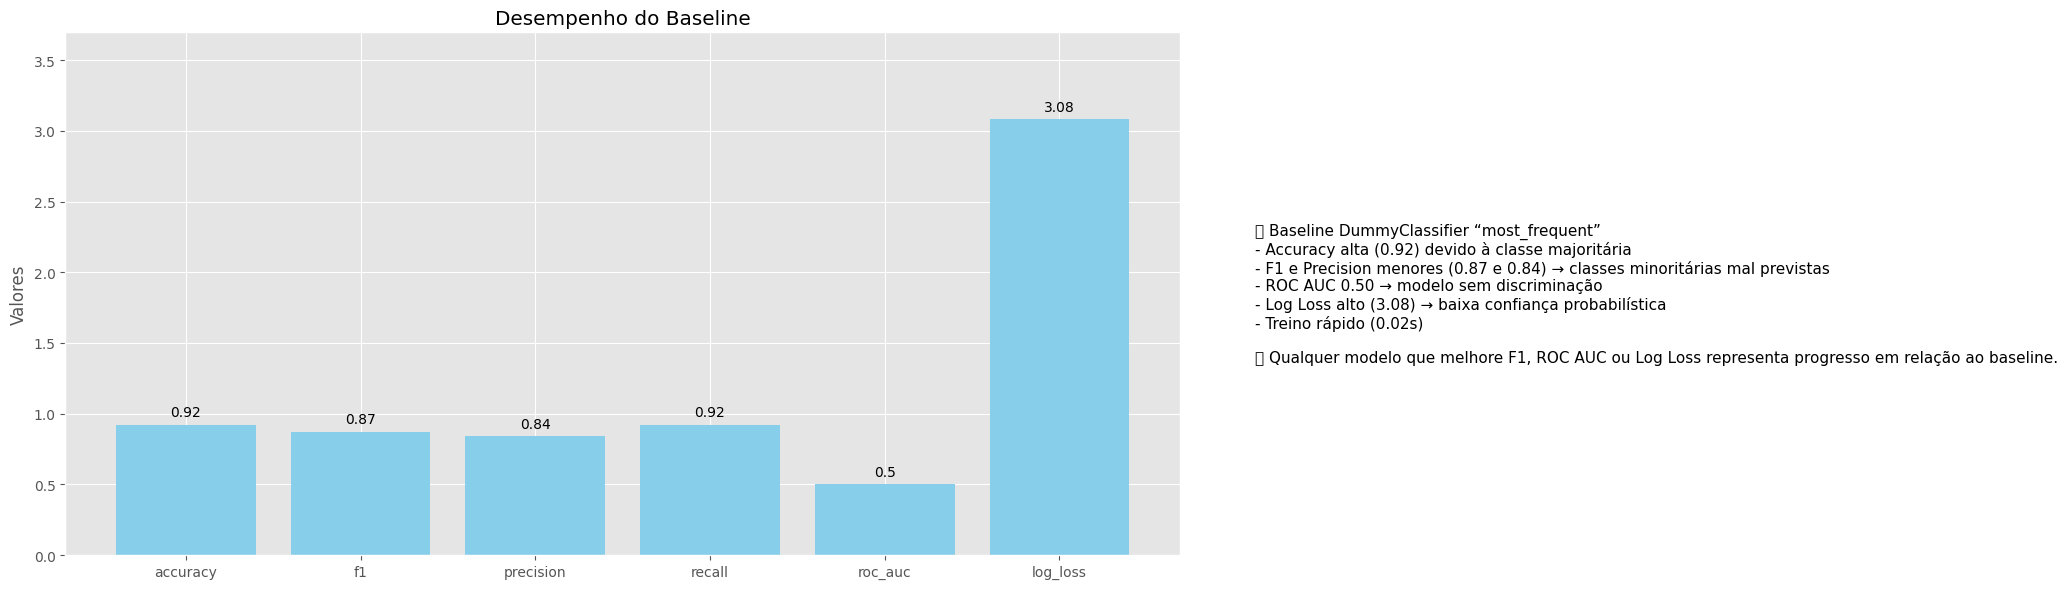

In [ ]:
import matplotlib.pyplot as plt

# ========================
# Dados do baseline
# ========================
metrics = ["accuracy", "f1", "precision", "recall", "roc_auc", "log_loss"]
values = [0.92, 0.87, 0.84, 0.92, 0.50, 3.08]

# ========================
# Figura combinada
# ========================
fig, ax = plt.subplots(figsize=(12,6))

# Gráfico de barras
ax.bar(metrics, values, color="skyblue")
ax.set_ylim(0, max(values)*1.2)
ax.set_ylabel("Valores")
ax.set_title("Desempenho do Baseline")

# Adiciona valores acima das barras
for i, v in enumerate(values):
    ax.text(i, v + 0.02*max(values), str(v), ha='center', fontsize=10)

# Texto resumido ao lado
conclusion_text = (
    "✅ Baseline DummyClassifier “most_frequent”\n"
    "- Accuracy alta (0.92) devido à classe majoritária\n"
    "- F1 e Precision menores (0.87 e 0.84) → classes minoritárias mal previstas\n"
    "- ROC AUC 0.50 → modelo sem discriminação\n"
    "- Log Loss alto (3.08) → baixa confiança probabilística\n"
    "- Treino rápido (0.02s)\n\n"
    "💡 Qualquer modelo que melhore F1, ROC AUC ou Log Loss representa progresso em relação ao baseline."
)

# Adiciona o texto na figura
plt.gcf().text(1.05, 0.5, conclusion_text, fontsize=11, va='center')

plt.tight_layout()
plt.show()


Usando mais modelos

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, log_loss
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)

# ========================
# Configurações principais
# ========================
SEED = 42
PROBLEM_TYPE = "classificacao"

# ========================
# Definição de target/features
# ========================
if PROBLEM_TYPE == "classificacao":
    target = "target"
    features = [c for c in df.columns if c != target]

elif PROBLEM_TYPE == "regressao":
    target = "target"
    features = [c for c in df.columns if c != target]

elif PROBLEM_TYPE == "clusterizacao":
    target = None
    features = [c for c in df.columns if c != "target"]

else:
    raise ValueError("❌ PROBLEM_TYPE inválido.")

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))

# ========================
# Split dos dados
# ========================
if PROBLEM_TYPE in ["classificacao", "regressao"]:
    X = df[features].copy()
    y = df[target].copy()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED,
        stratify=y if PROBLEM_TYPE == "classificacao" else None
    )
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)

elif PROBLEM_TYPE == "clusterizacao":
    X = df[features].copy()
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=SEED)
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)

# ========================
# Funções de avaliação
# ========================
def evaluate_classification(y_true, y_pred, proba=None):
    results = {
        "accuracy": round(accuracy_score(y_true, y_pred), 3),
        "f1": round(f1_score(y_true, y_pred, average="weighted"), 3),
        "precision": round(precision_score(y_true, y_pred, average="weighted", zero_division=0), 3),
        "recall": round(recall_score(y_true, y_pred, average="weighted"), 3)
    }
    if proba is not None:
        try:
            results["roc_auc"] = round(roc_auc_score(y_true, proba[:,1]), 3) if proba.shape[1]==2 else None
            results["log_loss"] = round(log_loss(y_true, proba), 3)
        except Exception:
            results["roc_auc"] = None
            results["log_loss"] = None
    return results

# ========================
# Definição dos modelos candidatos
# ========================
candidates = {
    "Dummy": DummyClassifier(strategy="most_frequent", random_state=SEED),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=SEED),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=SEED),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=SEED),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=SEED),
    "SVM": SVC(probability=True, random_state=SEED),
    "NaiveBayes": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=SEED)
}

# ========================
# Treino e avaliação
# ========================
results = {}

for name, model in candidates.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()

    y_pred = model.predict(X_test)
    proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    results[name] = evaluate_classification(y_test, y_pred, proba)
    results[name]["train_time_s"] = round(t1 - t0, 3)

# ========================
# Resultados finais + ranking
# ========================
df_results = pd.DataFrame(results).T
df_ranked = df_results.sort_values(by="accuracy", ascending=False)

print("\n📊 Resultados ordenados:")
print(df_ranked)


PROBLEM_TYPE: classificacao
Target: target
N features: 60
Treino: (243153, 64) | Teste: (60789, 64)


ValueError: could not convert string to float: 'Yes'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ========================
# Gráficos comparativos em subplots
# ========================
metrics_to_plot = [c for c in df_ranked.columns if c != "train_time_s"]
n_metrics = len(metrics_to_plot)

fig, axes = plt.subplots(nrows=2, ncols=(n_metrics+1)//2, figsize=(18,10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(
        x=df_ranked.index,
        y=df_ranked[metric],
        palette="Set2",
        ax=axes[i]
    )
    axes[i].set_title(metric.capitalize())
    axes[i].set_xticklabels(df_ranked.index, rotation=45)

    # Valores acima das barras
    for j, v in enumerate(df_ranked[metric]):
        axes[i].text(j, v + 0.02*df_ranked[metric].max(), str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
X = df.drop('target', axis=1)
y = df['target']
numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 5. Tratamento de Dados e Pipeline de Pré-processamento

In [ ]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, numerical_cols), ('cat', cat_transformer, categorical_cols)])

## 6. Baseline e Modelos Candidatos

In [ ]:
baseline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DummyClassifier(strategy='most_frequent'))])
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
print("Accuracy baseline:", accuracy_score(y_test, y_pred_base))

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42)
}
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.3f}, F1: {f1_score(y_test, y_pred):.3f}")

## 7. Validação e Otimização de Hiperparâmetros

In [ ]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5]
}
grid_search = GridSearchCV(
    Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))]),
    param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)

## 8. Avaliação Final, Análise de Erros e Limitações

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

## 9. Engenharia de Atributos (Opcional)
# Exemplo: criar bins de idade
# df['age_bin'] = pd.cut(df['age'], bins=[29,40,50,60,70,80], labels=False)

Eliminação de características com baixa variância

In [ ]:
df.apply(lambda x: x.nunique(), axis=0)